## The Competition

So I've done my best and I've gotten a pretty decent but quite confounded model that explains how ad-spending might affect voter turnout. Now we're going to simulate an election in which the parties have limited resources to allocate and get to choose how to spend them. We'll then compute the turnout for the normal electoral college as well as the proportional electoral vote. I think we're going to have to ignore the popular vote for this one since swing states generally get better turnout. But let's get cooking.

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import beta
from scipy.optimize import minimize

# Load data
county_df = pd.read_csv('countypres_2000-2024.csv')
ad_df = pd.read_csv('ad_data.csv')

# Prepare vote shares and population by state/year
state_partisan_votes = county_df[county_df['party'].isin(['DEMOCRAT', 'REPUBLICAN'])].groupby(
    ['year', 'state', 'party']
)['candidatevotes'].sum().unstack(fill_value=0).reset_index()
state_partisan_votes['DEM_SHARE'] = state_partisan_votes['DEMOCRAT'] / (state_partisan_votes['DEMOCRAT'] + state_partisan_votes['REPUBLICAN'])
state_partisan_votes['total_partisan'] = state_partisan_votes['DEMOCRAT'] + state_partisan_votes['REPUBLICAN']
state_partisan_votes = state_partisan_votes.sort_values(['state', 'year']).reset_index(drop=True)

def past_3_inverse_weights(series):
    s = series.shift(1)
    values = np.full(series.shape[0], np.nan)
    weights = np.array([1, 1/2, 1/3])
    for i in range(3, len(s)+1):
        window = s.iloc[i-3:i].values
        if np.isnan(window).any():
            continue
        weighted_avg = np.dot(window, weights) / np.sum(weights)
        values[i-1] = weighted_avg
    return pd.Series(values, index=series.index)

state_partisan_votes['Weighted-3-Year-Prior-DEM_SHARE'] = (
    state_partisan_votes.groupby('state')['DEM_SHARE'].transform(past_3_inverse_weights)
)
state_partisan_votes['state'] = state_partisan_votes['state'].str.upper()
ad_df['State'] = ad_df['State'].str.upper()

# Merge and clean
combined_data = ad_df.merge(
    state_partisan_votes[['year', 'state', 'total_partisan', 'DEM_SHARE', 'Weighted-3-Year-Prior-DEM_SHARE']],
    left_on=['year', 'State'],
    right_on=['year', 'state'],
    how='inner'
)
combined_data = combined_data[~((combined_data['State'] == 'IOWA') & (combined_data['year'] == 2016))]
combined_data['turnout_change'] = combined_data['DEM_SHARE'] - combined_data['Weighted-3-Year-Prior-DEM_SHARE']
combined_data = combined_data.dropna(subset=['D-ad-spending', 'R-ad-spending', 'turnout_change', 'total_partisan'])

# Setup arrays
D_spending = combined_data['D-ad-spending'].values
R_spending = combined_data['R-ad-spending'].values
turnout_change = combined_data['turnout_change'].values
total_partisan = combined_data['total_partisan'].values

# Transform to [0, 1] for beta regression
lower, upper = -0.2, 0.2
transformed_data = (turnout_change - lower) / (upper - lower)
transformed_data = np.clip(transformed_data, 1e-7, 1 - 1e-7)

# Define model (removed log terms)
def g(D, a1, a2):
    return a1 * D + a2 * D**2
def h(R, b1, b2):
    return b1 * R + b2 * R**2
a0_fixed = 12.5
b0_fixed = 12.5

def neg_log_likelihood_population_scaled(params):
    a1, a2, b1, b2 = params
    if np.any(np.array(params) < 0):
        return 1e12
    a_vals = a0_fixed + (1.0 / total_partisan) * g(D_spending, a1, a2)
    b_vals = b0_fixed + (1.0 / total_partisan) * h(R_spending, b1, b2)
    if np.any(a_vals <= 0) or np.any(b_vals <= 0):
        return 1e12
    ll = np.sum(beta.logpdf(transformed_data, a_vals, b_vals))
    return -ll

# Fit (now only 4 parameters: a1, a2, b1, b2)
initial_params = [1e6, 0.0, 1e6, 0.0]
widesup = 1e12
bounds = [(0, widesup)] * 4

result = minimize(neg_log_likelihood_population_scaled, initial_params, bounds=bounds, method='L-BFGS-B')
a1_opt, a2_opt, b1_opt, b2_opt = result.x

# Save the model parameters to kernel variables for use later
beta_model_a0_fixed = a0_fixed
beta_model_b0_fixed = b0_fixed
beta_model_a1 = float(a1_opt)
beta_model_a2 = float(a2_opt)
beta_model_b1 = float(b1_opt)
beta_model_b2 = float(b2_opt)

print("Democrat-induced model (g(D)):")
print(f"    g(D) = {beta_model_a1:.3g} * D + {beta_model_a2:.3g} * D^2")

print("Republican-induced model (h(R)):")
print(f"    h(R) = {beta_model_b1:.3g} * R + {beta_model_b2:.3g} * R^2")


Democrat-induced model (g(D)):
    g(D) = 5.36e+05 * D + 0 * D^2
Republican-induced model (h(R)):
    h(R) = 1.06e+06 * R + 0 * R^2


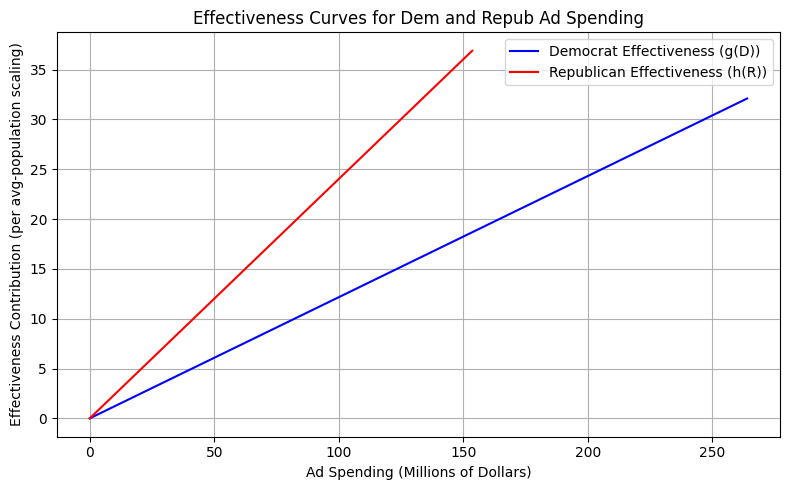

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Create a range of ad spending values (millions of dollars)
D_range = np.linspace(0, np.max(D_spending) * 1.2, 200)
R_range = np.linspace(0, np.max(R_spending) * 1.2, 200)

# Average total_partisan for reference in curves (since model is population-scaled)
avg_total_partisan = np.mean(total_partisan)

# Democrat effectiveness: predicted increase in (transformed) turnout change per extra D ad dollar
dem_eff = (1.0 / avg_total_partisan) * (
    beta_model_a1 * D_range + beta_model_a2 * D_range ** 2
)
# Republican effectiveness: predicted increase in (transformed) turnout change per extra R ad dollar (negative effect)
rep_eff = (1.0 / avg_total_partisan) * (
    beta_model_b1 * R_range + beta_model_b2 * R_range ** 2
)

plt.figure(figsize=(8, 5))
plt.plot(D_range, dem_eff, label="Democrat Effectiveness (g(D))", color='blue')
plt.plot(R_range, rep_eff, label="Republican Effectiveness (h(R))", color='red')
plt.xlabel("Ad Spending (Millions of Dollars)")
plt.ylabel("Effectiveness Contribution (per avg-population scaling)")
plt.title("Effectiveness Curves for Dem and Repub Ad Spending")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
import pandas as pd

# Load ad spending data from just_ad_data.csv
ad_df = pd.read_csv('just_ad_data.csv')

# Calculate, across the four years, the k where average Republican funds * k = average Democrat funds
avg_D_funds = ad_df['D-ad-spending'].mean()
avg_R_funds = ad_df['R-ad-spending'].mean()

k = avg_D_funds / avg_R_funds
print('Democrats outspend republicans by a factor of', k)

Democrats outspend republicans by a factor of 1.6279974534908397


## Let's get to work


SEARCHING FOR OPTIMAL k_baseline WITH MULTIPLE INITIALIZATIONS

Trying k_baseline = 50...
  Best Neg Log-Likelihood: -40.7739 (from 50 random starts)

Trying k_baseline = 100...
  Best Neg Log-Likelihood: -64.2525 (from 50 random starts)

Trying k_baseline = 150...
  Best Neg Log-Likelihood: -65.3965 (from 50 random starts)

Trying k_baseline = 200...
  Best Neg Log-Likelihood: -77.6618 (from 50 random starts)

Trying k_baseline = 300...
  Best Neg Log-Likelihood: -75.7763 (from 50 random starts)

Trying k_baseline = 500...
  Best Neg Log-Likelihood: -70.3234 (from 50 random starts)

Trying k_baseline = 750...
  Best Neg Log-Likelihood: -60.3340 (from 50 random starts)

Trying k_baseline = 1000...
  Best Neg Log-Likelihood: -44.1836 (from 50 random starts)

Trying k_baseline = 1500...
  Best Neg Log-Likelihood: -14.7502 (from 50 random starts)

Trying k_baseline = 2000...
  Best Neg Log-Likelihood: 19.4947 (from 50 random starts)

Trying k_baseline = 2500...
  Best Neg Log-Likelihood:

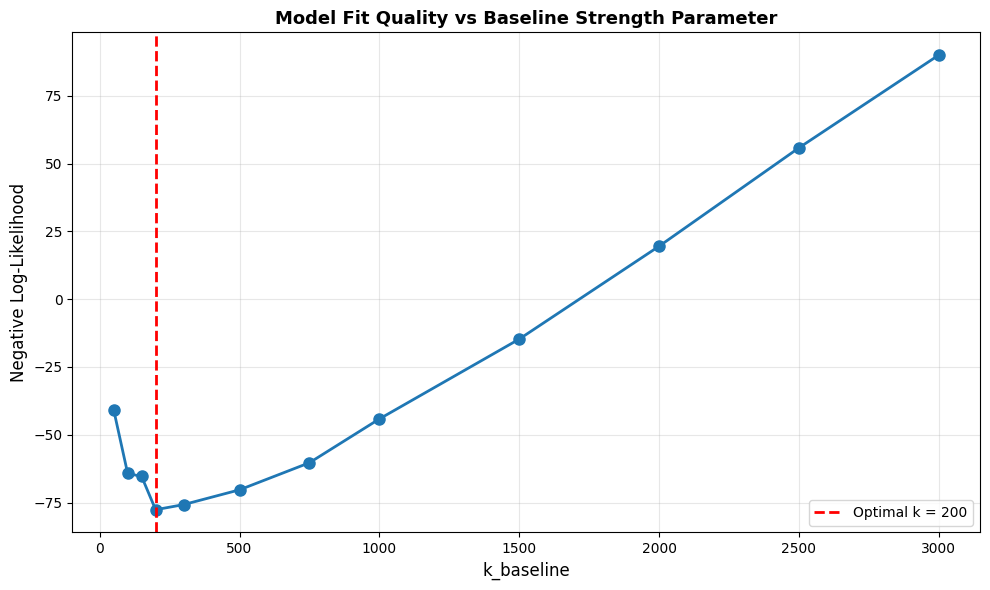

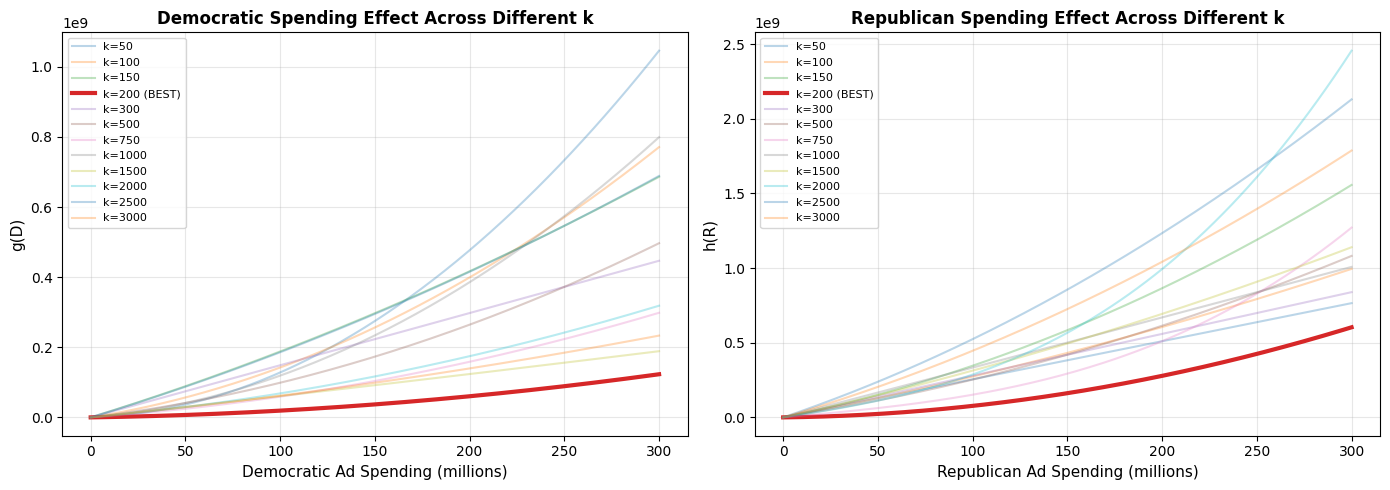


FINAL FIT WITH OPTIMAL k

Democratic spending effect g(D):
  g1   = 84107.08985252296
  g2   = 0.0
  g3   = 0.0

Republican spending effect h(R):
  h1   = 150558.40856321296
  h2   = 2061.255228874294
  h3   = 0.0

Optimal k_baseline = 200
Final neg log-likelihood: -78.7458

Model fit:
  Mean absolute error: 0.0272
  RMSE: 0.0318

PLOTTING OPTIMAL SPENDING EFFECT FUNCTIONS


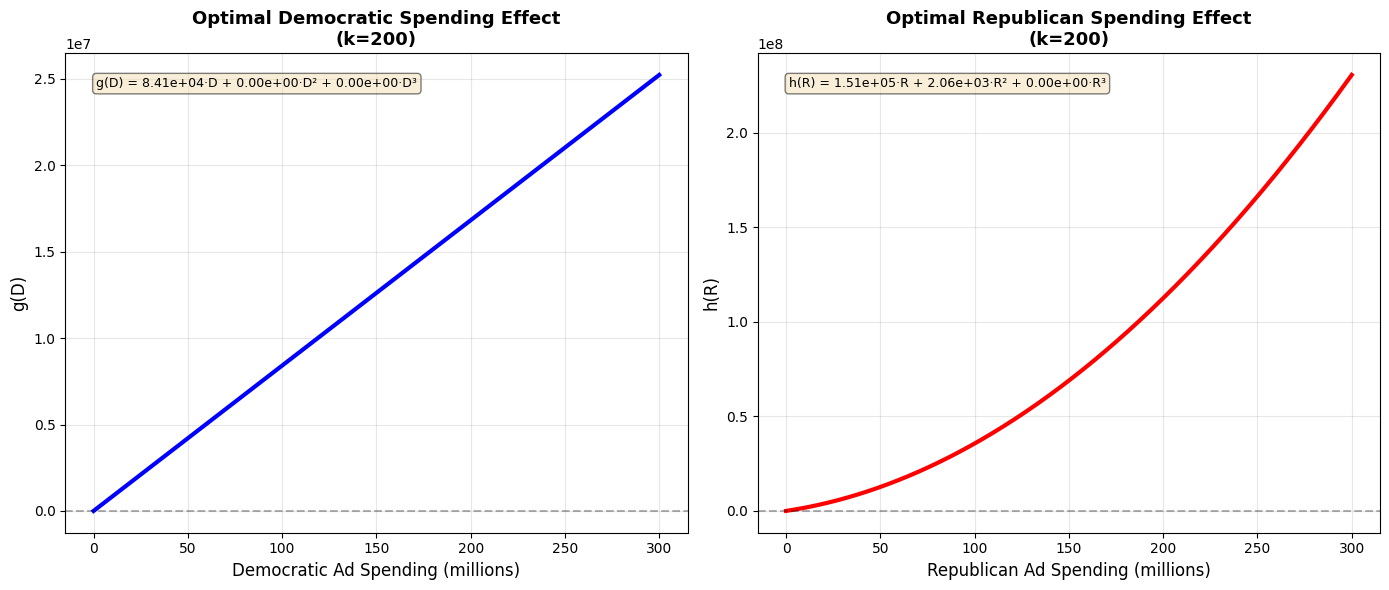


GENERATING STATE-BY-STATE BETA DISTRIBUTIONS


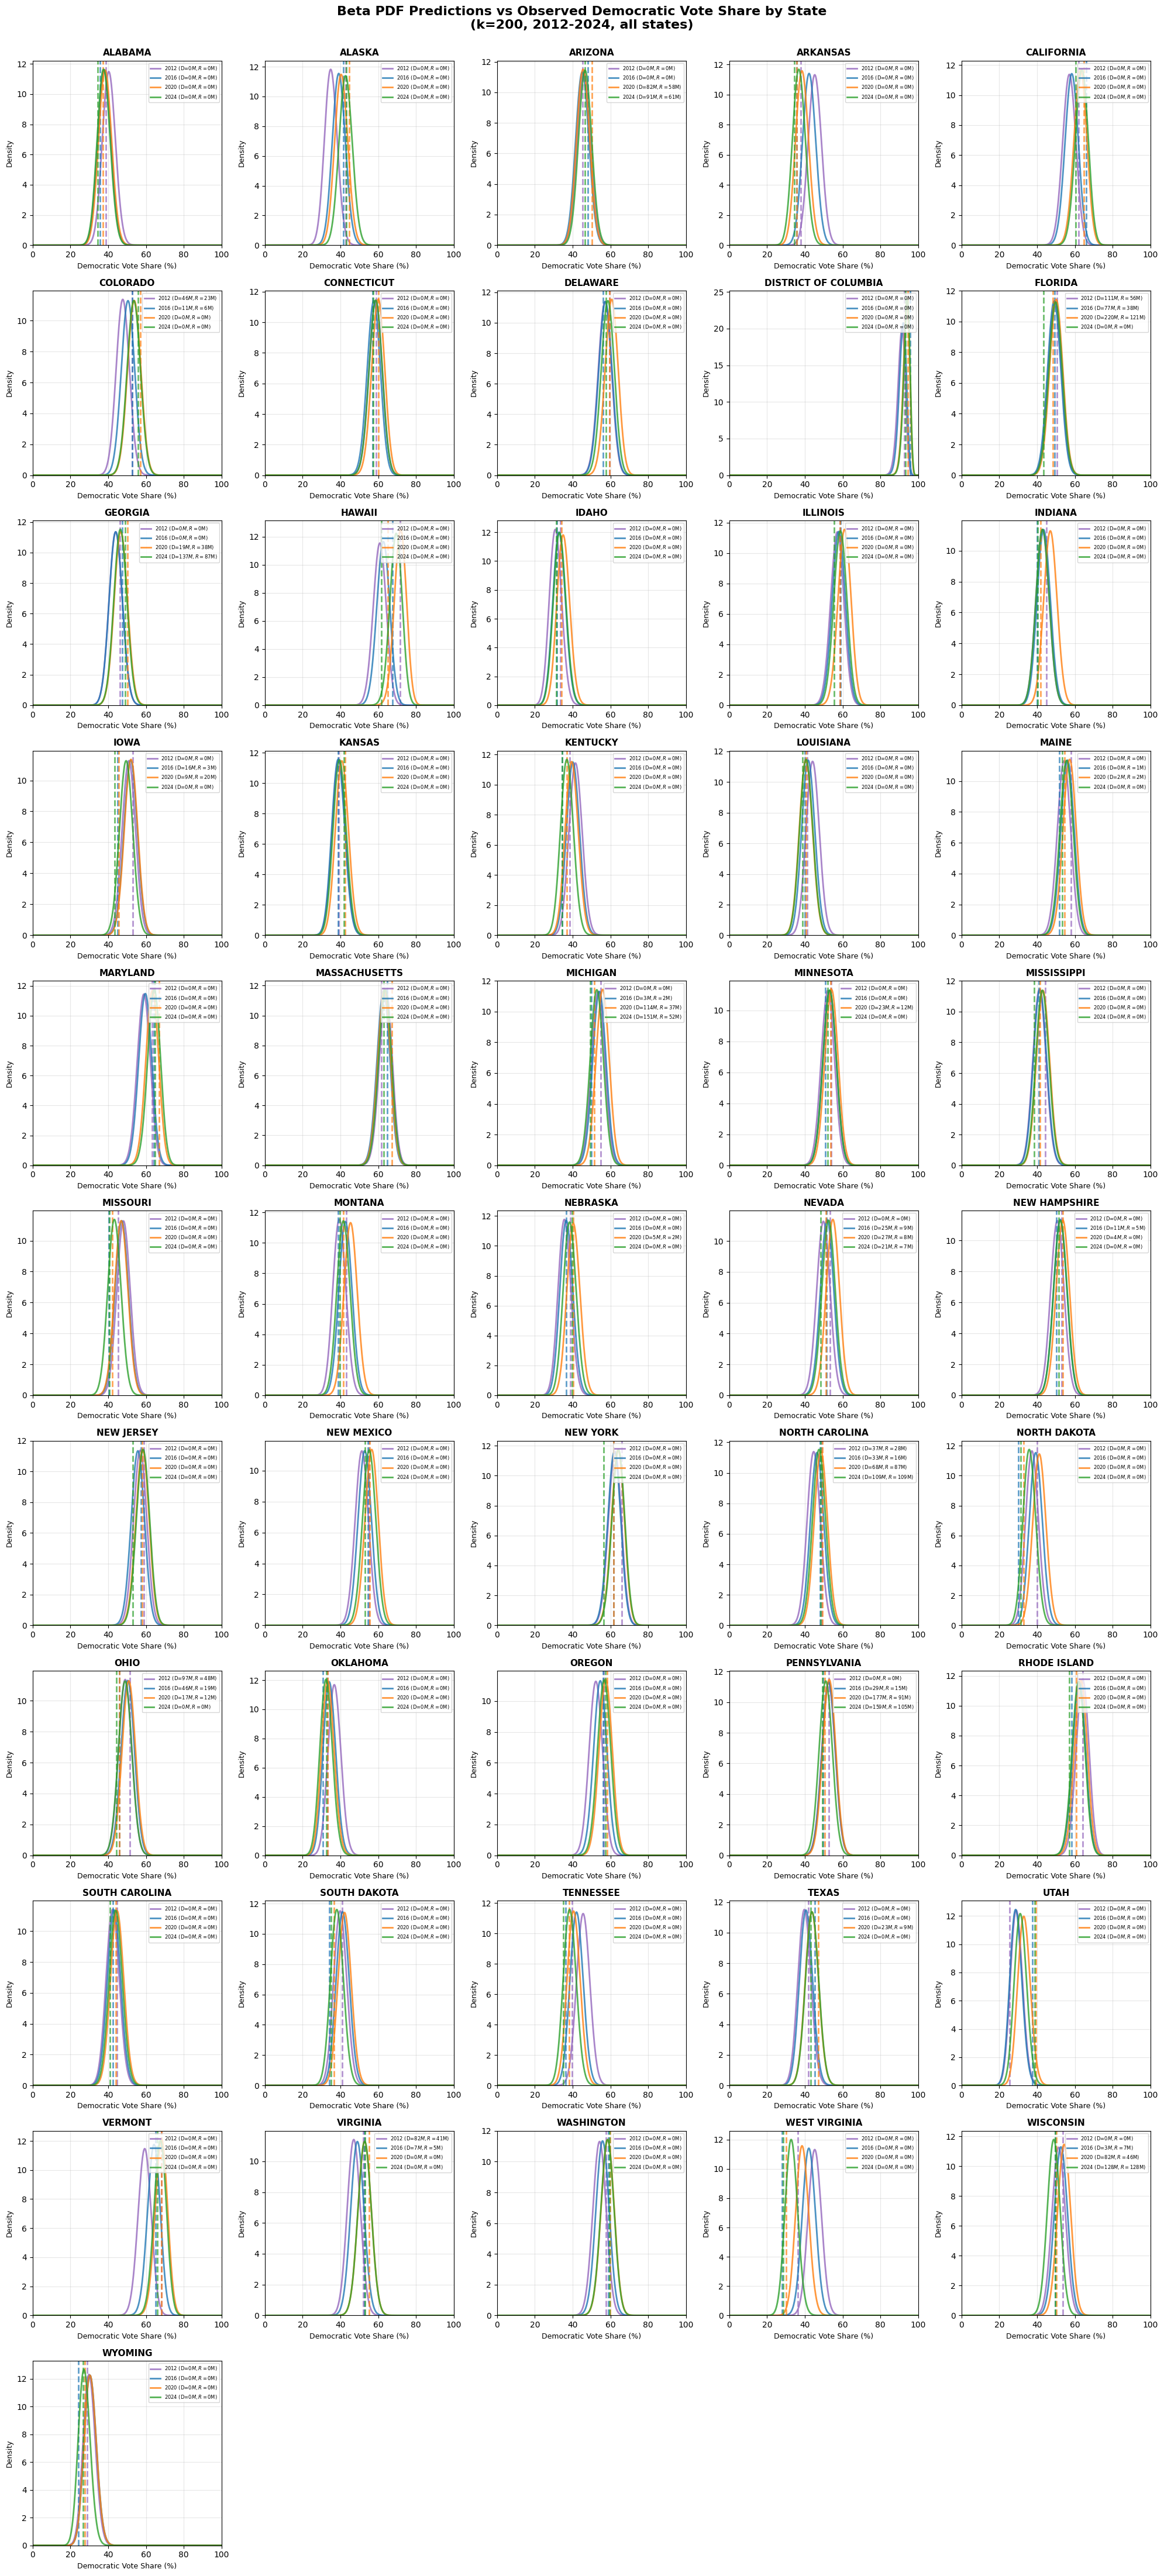


SENSITIVITY ANALYSIS: WYOMING, TEXAS, OHIO 2016

WYOMING: Pop=230,392, Baseline=0.306, Actual=0.243


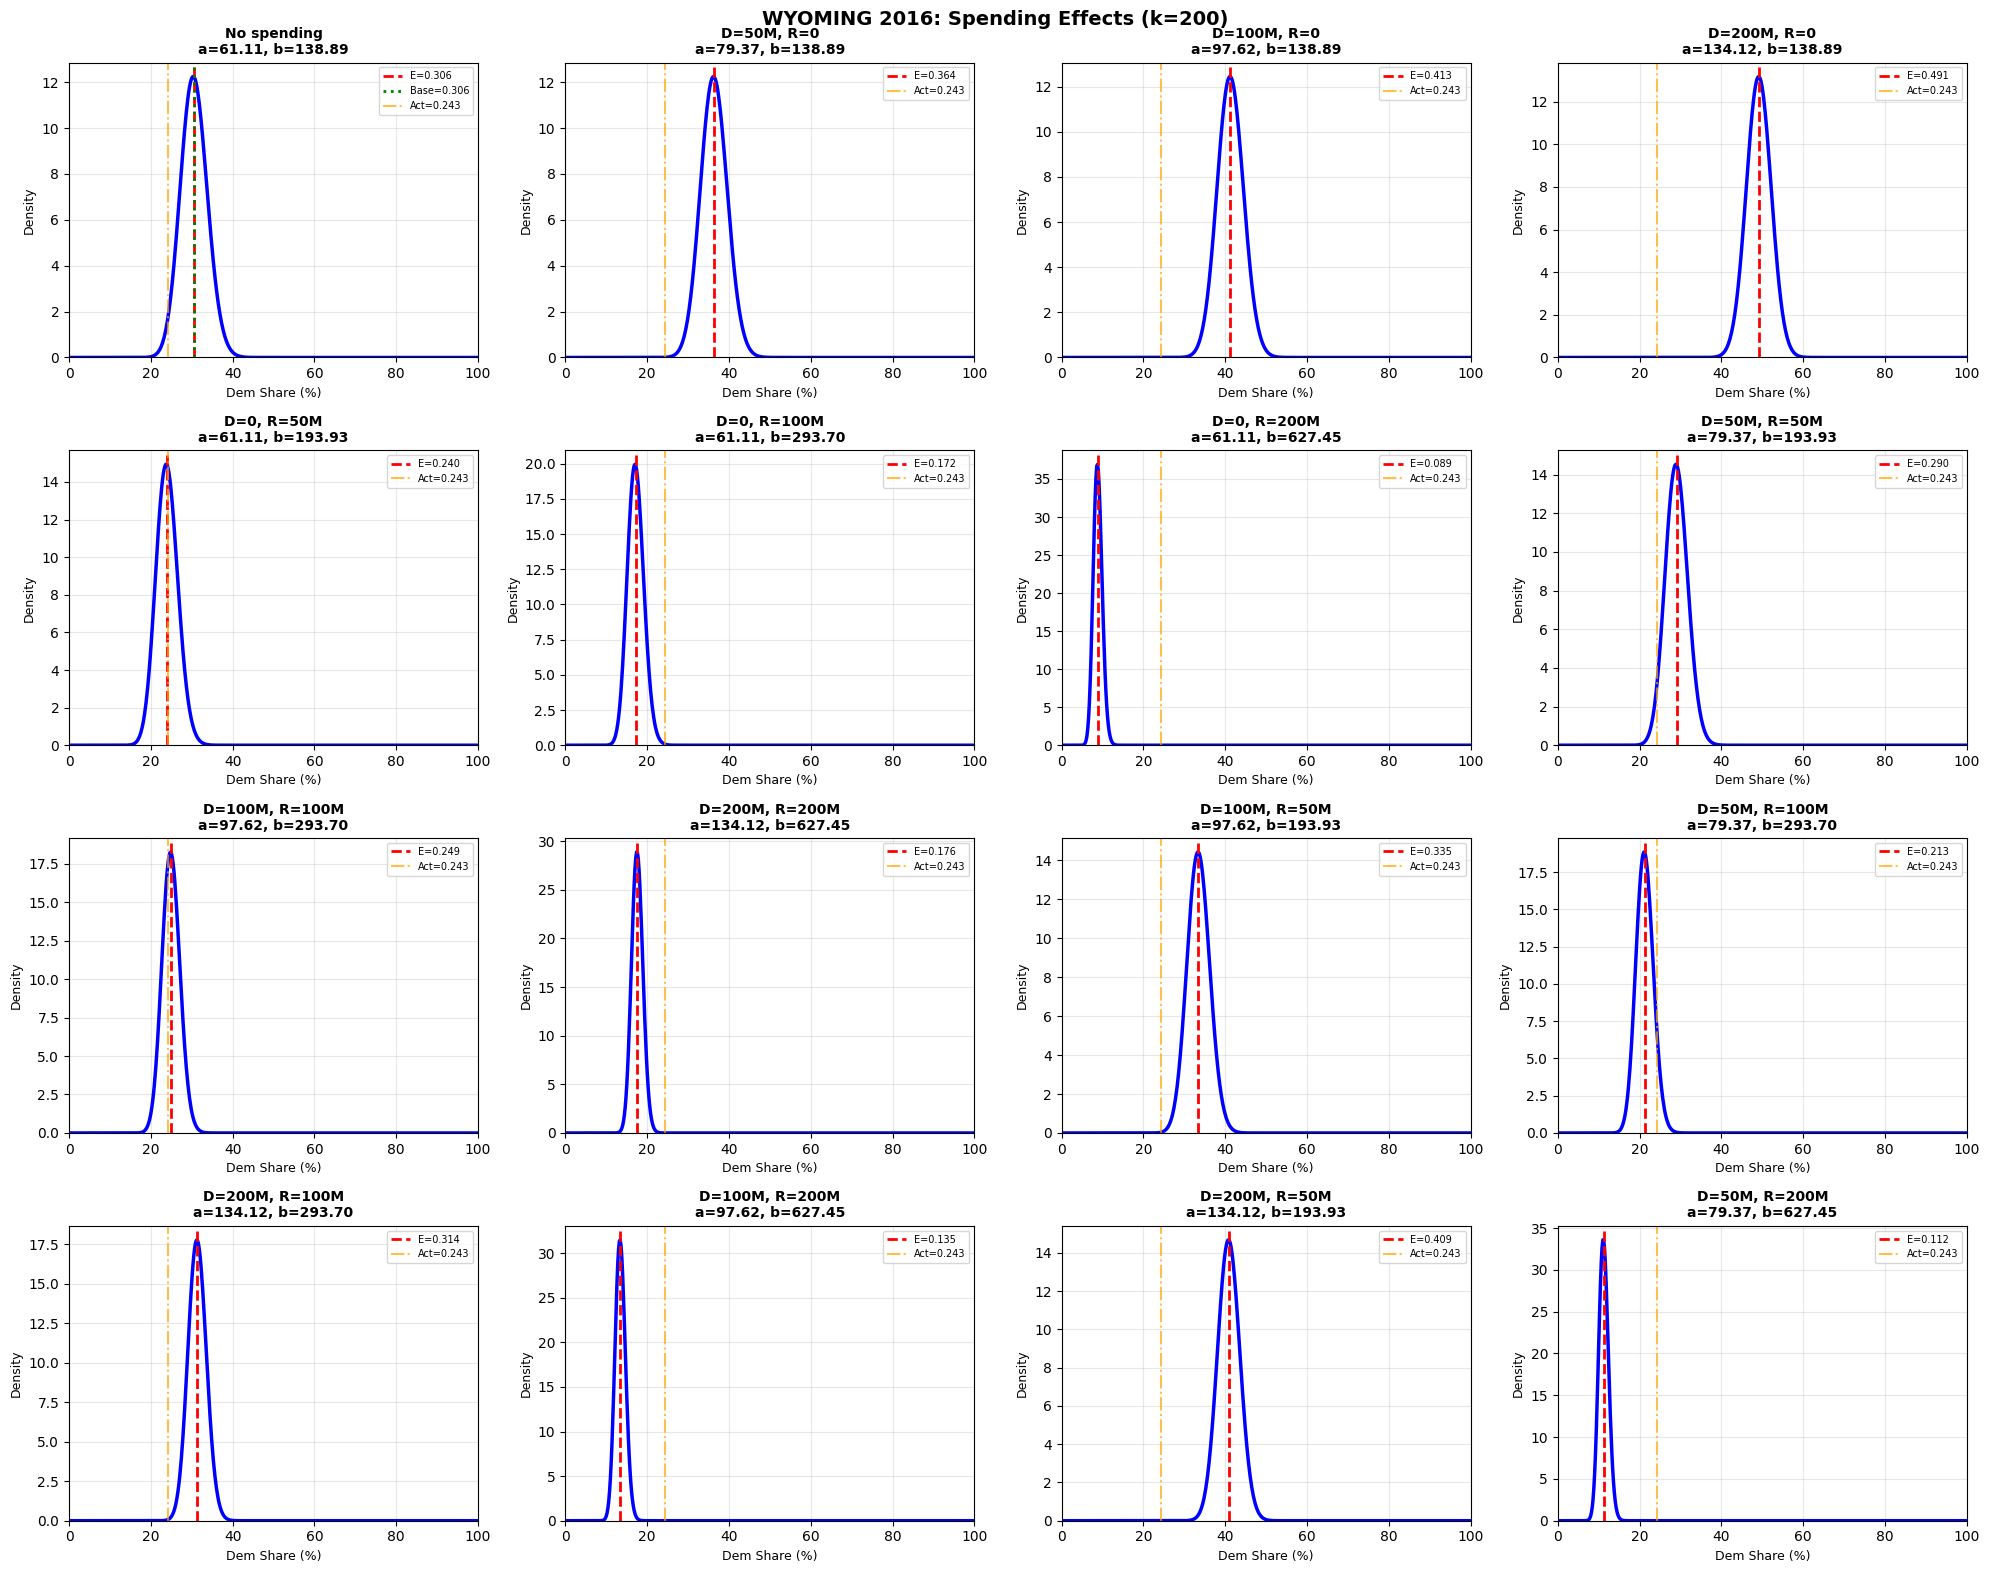


TEXAS: Pop=8,562,915, Baseline=0.406, Actual=0.453


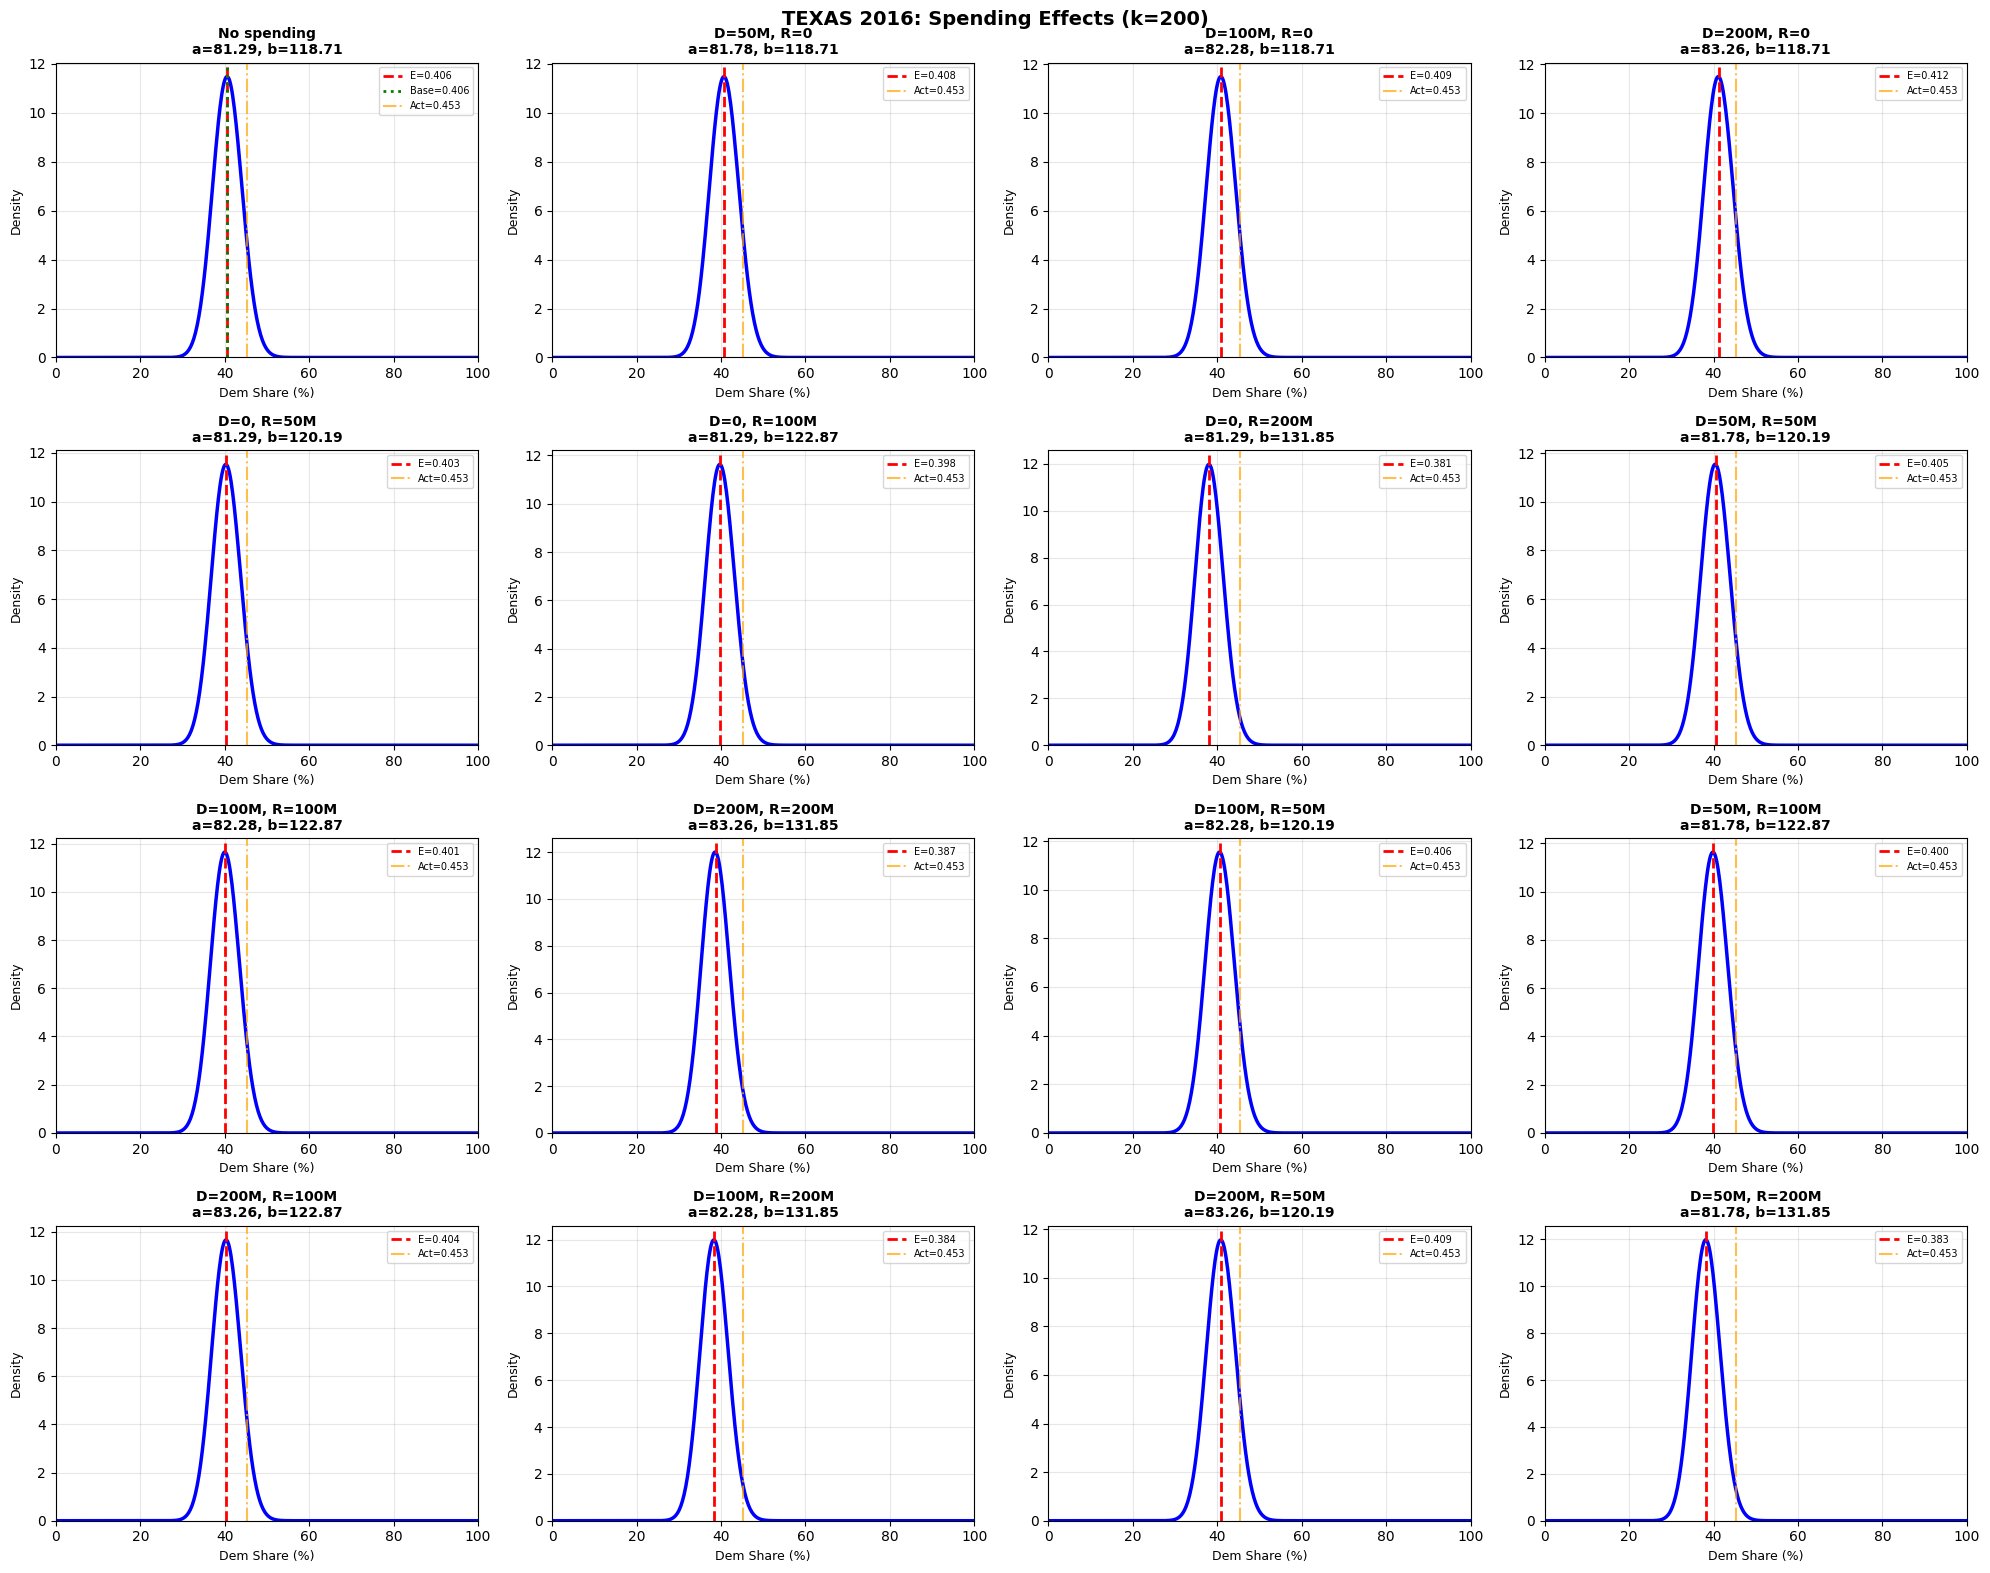


OHIO: Pop=5,235,169, Baseline=0.503, Actual=0.457


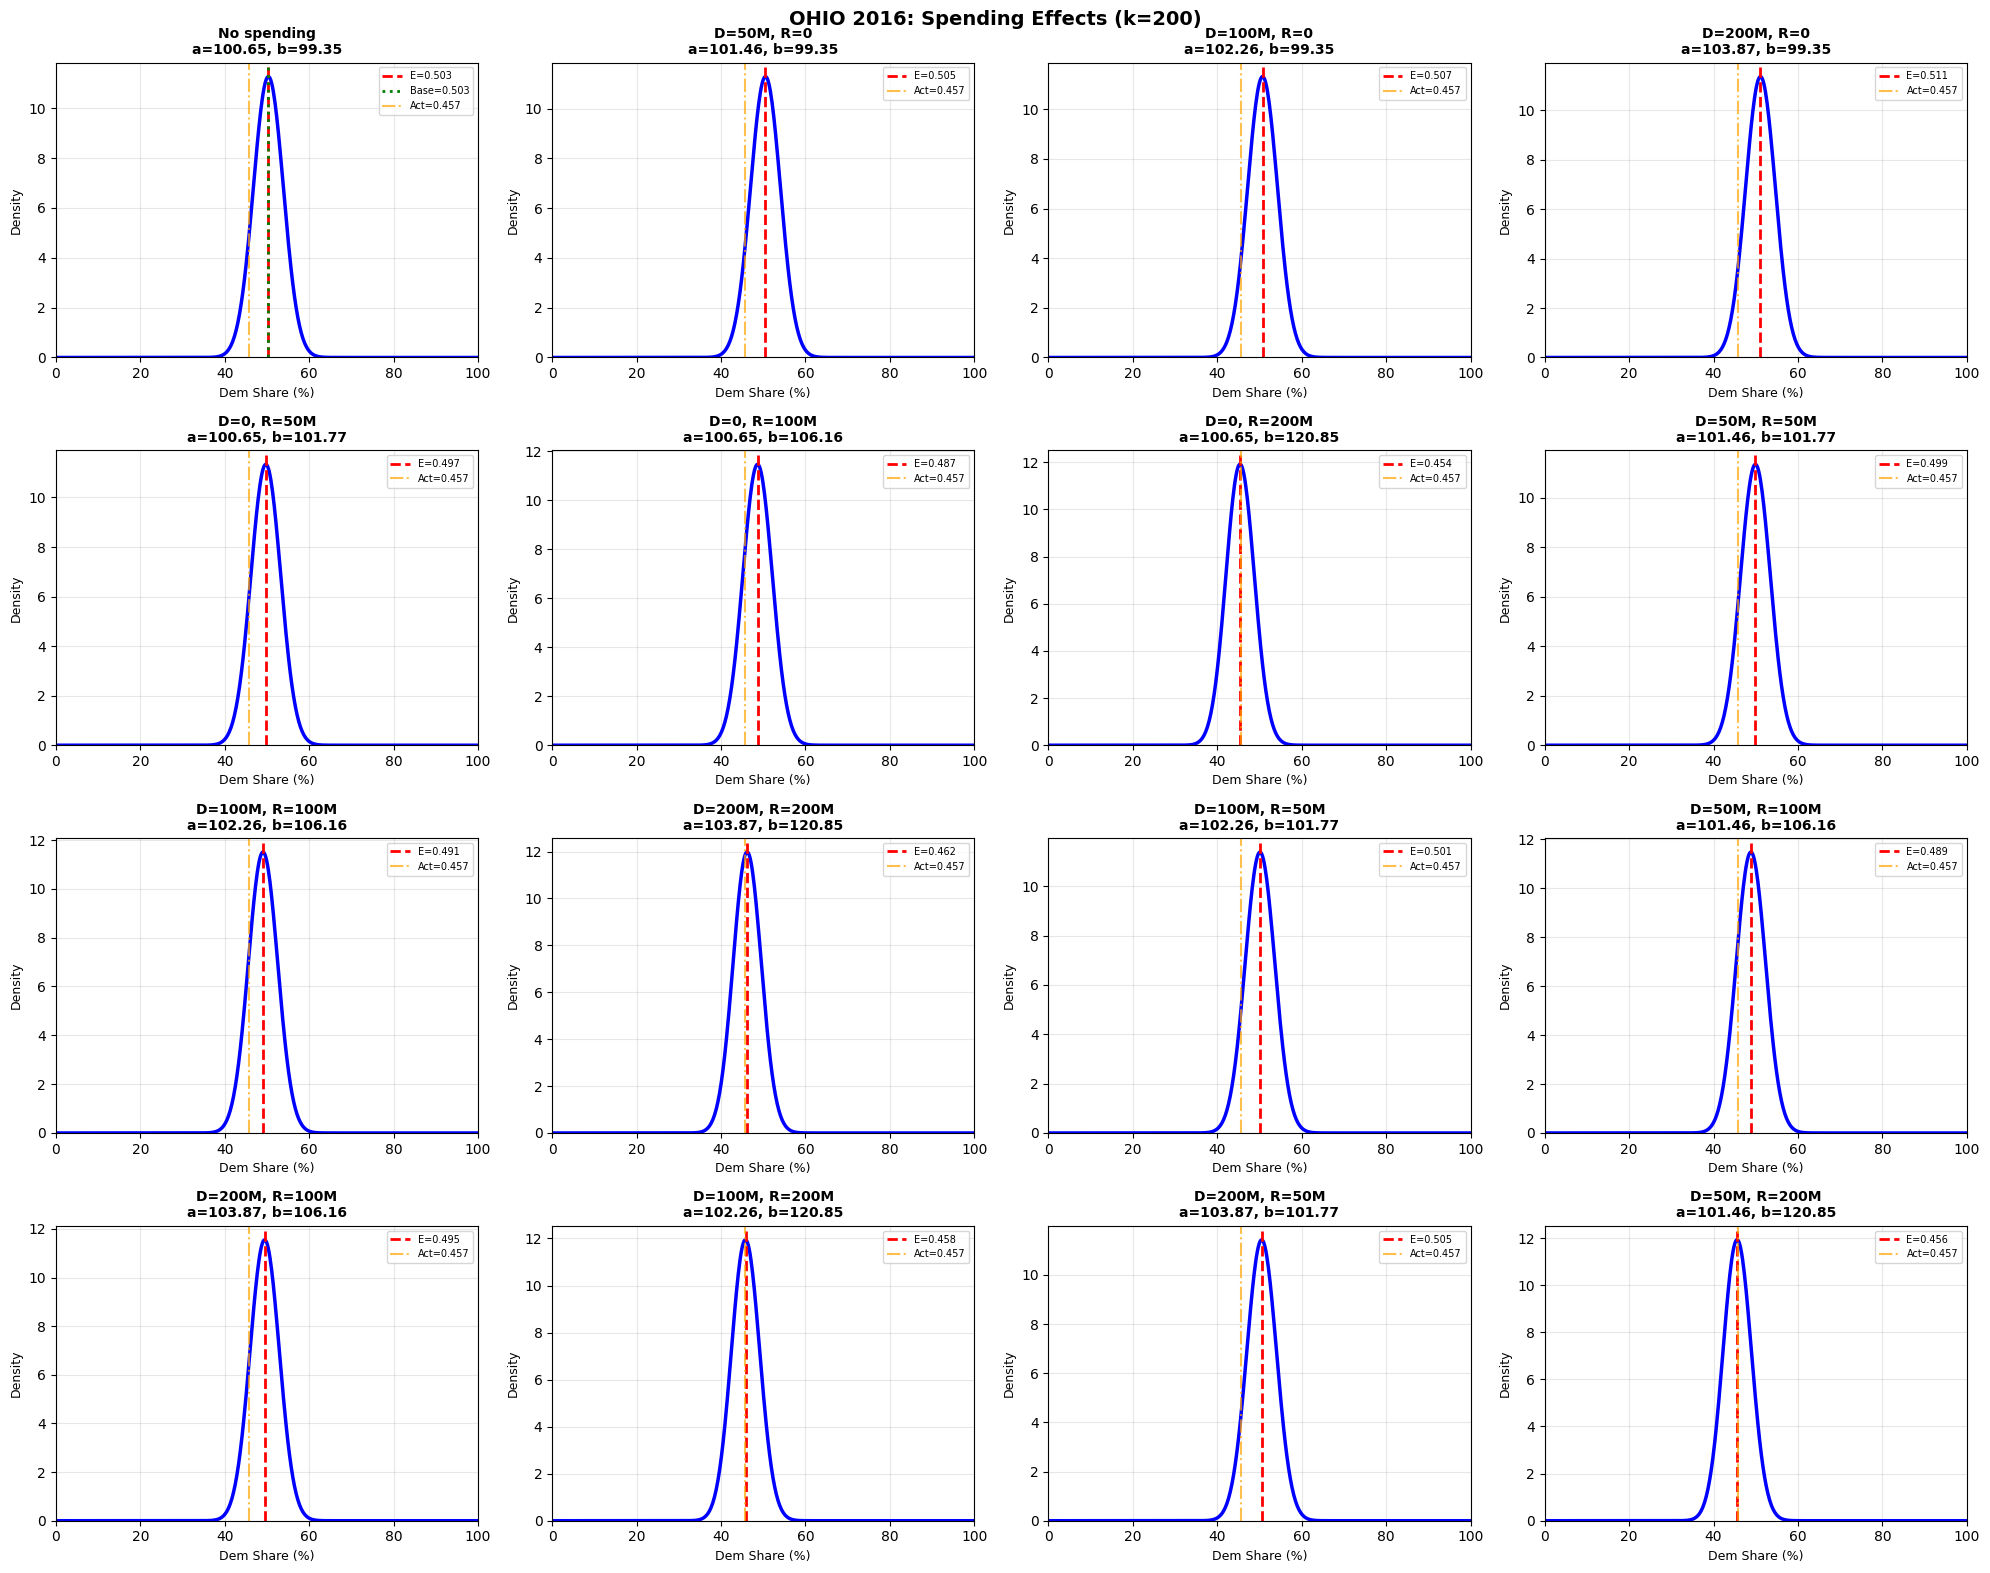


MODEL SUMMARY
Optimal k = 200
Use these fitted parameters for simulation:
  g(D) and h(R) functions with coefficients above


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from scipy.optimize import minimize

# Load data
county_df = pd.read_csv('countypres_2000-2024.csv')
ad_df = pd.read_csv('ad_data.csv')

# --- Calculate Democratic Vote Share by State and Year ---
state_partisan_votes = county_df[county_df['party'].isin(['DEMOCRAT', 'REPUBLICAN'])].groupby(
    ['year', 'state', 'party']
)['candidatevotes'].sum().unstack(fill_value=0).reset_index()

state_partisan_votes['DEM_SHARE'] = state_partisan_votes['DEMOCRAT'] / (
    state_partisan_votes['DEMOCRAT'] + state_partisan_votes['REPUBLICAN'])
state_partisan_votes['total_partisan'] = state_partisan_votes['DEMOCRAT'] + state_partisan_votes['REPUBLICAN']
state_partisan_votes = state_partisan_votes.sort_values(['state', 'year']).reset_index(drop=True)

# Calculate weighted 3-year prior Democratic share (baseline partisan lean)
def past_3_inverse_weights(series):
    s = series.shift(1)
    values = np.full(series.shape[0], np.nan)
    weights = np.array([1, 1/2, 1/3])
    for i in range(3, len(s)+1):
        window = s.iloc[i-3:i].values
        if np.isnan(window).any():
            continue
        weighted_avg = np.dot(window, weights) / np.sum(weights)
        values[i-1] = weighted_avg
    return pd.Series(values, index=series.index)

state_partisan_votes['Baseline_DEM_SHARE'] = (
    state_partisan_votes.groupby('state')['DEM_SHARE'].transform(past_3_inverse_weights)
)

# Standardize state names
state_partisan_votes['state'] = state_partisan_votes['state'].str.upper()
ad_df['State'] = ad_df['State'].str.upper()

# Merge with ad spending
combined_data = ad_df.merge(
    state_partisan_votes[['year', 'state', 'total_partisan', 'DEM_SHARE', 'Baseline_DEM_SHARE']],
    left_on=['year', 'State'],
    right_on=['year', 'state'],
    how='inner'
)

# Filter out Iowa 2016
combined_data = combined_data[~((combined_data['State'] == 'IOWA') & (combined_data['year'] == 2016))]
combined_data = combined_data.dropna(subset=['D-ad-spending', 'R-ad-spending', 'DEM_SHARE', 'total_partisan', 'Baseline_DEM_SHARE'])

eps = 1e-7

# === Define model functions ===
def g(D, g1, g2, g3):
    """Democratic spending effect - g(0) = 0"""
    return g1 * D + g2 * D**2 + g3 * D**3

def h(R, h1, h2, h3):
    """Republican spending effect - h(0) = 0"""
    return h1 * R + h2 * R**2 + h3 * R**3

def neg_log_likelihood(params, D_spending, R_spending, dem_share_clipped, total_partisan, p_D_fixed, p_R_fixed):
    """Negative log-likelihood for optimization"""
    g1, g2, g3 = params[0:3]
    h1, h2, h3 = params[3:6]
    
    if np.any(np.array([g1, g2, g3, h1, h2, h3]) < 0):
        return 1e12
    
    g_vals = g(D_spending, g1, g2, g3)
    h_vals = h(R_spending, h1, h2, h3)
    
    a_vals = (1.0 / total_partisan) * g_vals + p_D_fixed
    b_vals = (1.0 / total_partisan) * h_vals + p_R_fixed
    
    if np.any(a_vals <= 0) or np.any(b_vals <= 0):
        return 1e12
    
    ll = np.sum(beta.logpdf(dem_share_clipped, a_vals, b_vals))
    return -ll

# Initial parameters and bounds (remove log/exp terms: only 3 per function)
# Start from DIFFERENT initial values to avoid getting stuck
initial_params = np.array([5e5, 1e3, 10, 5e5, 1e3, 10])

# FULLY RELAXED bounds - let optimizer find natural values
bounds = [
    (0, None), (0, None), (0, None),  # g - no upper bounds!
    (0, None), (0, None), (0, None),  # h - no upper bounds!
]

# === PARAMETER SEARCH FOR OPTIMAL k_baseline ===
print("\n" + "="*80)
print("SEARCHING FOR OPTIMAL k_baseline WITH MULTIPLE INITIALIZATIONS")
print("="*80)

k_values = [50, 100, 150, 200, 300, 500, 750, 1000, 1500, 2000, 2500, 3000]
results_by_k = []

n_random_starts = 50  # Try 50 different random initializations per k

for k_baseline in k_values:
    print(f"\nTrying k_baseline = {k_baseline}...")
    
    combined_data['p_D'] = k_baseline * combined_data['Baseline_DEM_SHARE']
    combined_data['p_R'] = k_baseline * (1 - combined_data['Baseline_DEM_SHARE'])
    
    D_spending = combined_data['D-ad-spending'].values
    R_spending = combined_data['R-ad-spending'].values
    dem_share = combined_data['DEM_SHARE'].values
    total_partisan = combined_data['total_partisan'].values
    p_D_fixed = combined_data['p_D'].values
    p_R_fixed = combined_data['p_R'].values
    dem_share_clipped = np.clip(dem_share, eps, 1 - eps)
    
    best_nll = np.inf
    best_params_for_k = None
    best_success = False
    
    # Try multiple random initializations
    for i in range(n_random_starts):
        # Random initialization: only 3 terms each
        random_init = np.array([
            np.random.uniform(1e4, 1e7),  # g1
            np.random.uniform(0, 1e4),    # g2
            np.random.uniform(0, 1e3),    # g3
            np.random.uniform(1e4, 1e7),  # h1
            np.random.uniform(0, 1e4),    # h2
            np.random.uniform(0, 1e3),    # h3
        ])
        
        result_k = minimize(
            lambda p: neg_log_likelihood(p, D_spending, R_spending, dem_share_clipped, total_partisan, p_D_fixed, p_R_fixed),
            random_init, bounds=bounds, method='L-BFGS-B', options={'maxiter': 1000, 'ftol': 1e-8}
        )
        
        if result_k.success and result_k.fun < best_nll:
            best_nll = result_k.fun
            best_params_for_k = result_k.x.copy()
            best_success = True
    
    results_by_k.append({
        'k_baseline': k_baseline,
        'neg_log_likelihood': best_nll,
        'success': best_success,
        'params': best_params_for_k
    })
    
    print(f"  Best Neg Log-Likelihood: {best_nll:.4f} (from {n_random_starts} random starts)")

# Find best k
results_df = pd.DataFrame(results_by_k)
best_idx = results_df['neg_log_likelihood'].idxmin()
best_k = results_df.loc[best_idx, 'k_baseline']
best_params = results_df.loc[best_idx, 'params']

print("\n" + "="*80)
print("k_baseline SEARCH RESULTS")
print("="*80)
print(results_df[['k_baseline', 'neg_log_likelihood', 'success']].to_string(index=False))
print(f"\nOPTIMAL k_baseline = {best_k}")

# Plot likelihood vs k
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(results_df['k_baseline'], results_df['neg_log_likelihood'], 'o-', lw=2, markersize=8)
ax.axvline(best_k, color='r', linestyle='--', lw=2, label=f'Optimal k = {best_k}')
ax.set_xlabel('k_baseline', fontsize=12)
ax.set_ylabel('Negative Log-Likelihood', fontsize=12)
ax.set_title('Model Fit Quality vs Baseline Strength Parameter', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot spending effect curves for different k values
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

D_range_viz = np.linspace(0, 300, 200)  # 0 to 300M spending
R_range_viz = np.linspace(0, 300, 200)

for i, row in results_df.iterrows():
    if row['success'] and row['params'] is not None:
        k_val = row['k_baseline']
        params = row['params']
        g1, g2, g3 = params[0:3]
        h1, h2, h3 = params[3:6]
        
        g_curve = g(D_range_viz, g1, g2, g3)
        h_curve = h(R_range_viz, h1, h2, h3)
        
        alpha = 0.3 if k_val != best_k else 1.0
        lw = 1.5 if k_val != best_k else 3.0
        label = f'k={k_val}' + (' (BEST)' if k_val == best_k else '')
        
        axes[0].plot(D_range_viz, g_curve, alpha=alpha, lw=lw, label=label)
        axes[1].plot(R_range_viz, h_curve, alpha=alpha, lw=lw, label=label, color=f'C{i}')

axes[0].set_xlabel('Democratic Ad Spending (millions)', fontsize=11)
axes[0].set_ylabel('g(D)', fontsize=11)
axes[0].set_title('Democratic Spending Effect Across Different k', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=8)
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Republican Ad Spending (millions)', fontsize=11)
axes[1].set_ylabel('h(R)', fontsize=11)
axes[1].set_title('Republican Spending Effect Across Different k', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=8)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# === FIT FINAL MODEL WITH OPTIMAL k ===
k_baseline = best_k
combined_data['p_D'] = k_baseline * combined_data['Baseline_DEM_SHARE']
combined_data['p_R'] = k_baseline * (1 - combined_data['Baseline_DEM_SHARE'])

D_spending = combined_data['D-ad-spending'].values
R_spending = combined_data['R-ad-spending'].values
dem_share = combined_data['DEM_SHARE'].values
total_partisan = combined_data['total_partisan'].values
p_D_fixed = combined_data['p_D'].values
p_R_fixed = combined_data['p_R'].values
dem_share_clipped = np.clip(dem_share, eps, 1 - eps)

print("\n" + "="*80)
print("FINAL FIT WITH OPTIMAL k")
print("="*80)

result = minimize(
    lambda p: neg_log_likelihood(p, D_spending, R_spending, dem_share_clipped, total_partisan, p_D_fixed, p_R_fixed),
    best_params, bounds=bounds, method='L-BFGS-B', options={'maxiter': 2000, 'ftol': 1e-9}
)

g1_opt, g2_opt, g3_opt = result.x[0:3]
h1_opt, h2_opt, h3_opt = result.x[3:6]

print(f"\nDemocratic spending effect g(D):")
print(f"  g1   = {g1_opt}")
print(f"  g2   = {g2_opt}")
print(f"  g3   = {g3_opt}")

print(f"\nRepublican spending effect h(R):")
print(f"  h1   = {h1_opt}")
print(f"  h2   = {h2_opt}")
print(f"  h3   = {h3_opt}")

print(f"\nOptimal k_baseline = {k_baseline}")
print(f"Final neg log-likelihood: {result.fun:.4f}")

# Calculate fitted values for diagnostics
g_vals_fitted = g(D_spending, g1_opt, g2_opt, g3_opt)
h_vals_fitted = h(R_spending, h1_opt, h2_opt, h3_opt)
a_fitted = (1.0 / total_partisan) * g_vals_fitted + p_D_fixed
b_fitted = (1.0 / total_partisan) * h_vals_fitted + p_R_fixed
predicted_share = a_fitted / (a_fitted + b_fitted)

residuals = dem_share - predicted_share
print(f"\nModel fit:")
print(f"  Mean absolute error: {np.mean(np.abs(residuals)):.4f}")
print(f"  RMSE: {np.sqrt(np.mean(residuals**2)):.4f}")

# === PLOT FINAL OPTIMAL g(D) AND h(R) FUNCTIONS ===
print("\n" + "="*80)
print("PLOTTING OPTIMAL SPENDING EFFECT FUNCTIONS")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

D_range_final = np.linspace(0, 300, 500)
R_range_final = np.linspace(0, 300, 500)

g_final = g(D_range_final, g1_opt, g2_opt, g3_opt)
h_final = h(R_range_final, h1_opt, h2_opt, h3_opt)

axes[0].plot(D_range_final, g_final, 'b-', lw=3)
axes[0].set_xlabel('Democratic Ad Spending (millions)', fontsize=12)
axes[0].set_ylabel('g(D)', fontsize=12)
axes[0].set_title(f'Optimal Democratic Spending Effect\n(k={k_baseline})', 
                  fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(0, color='k', linestyle='--', alpha=0.3)

# Add text showing equation
g_text = (f"g(D) = {g1_opt:.2e}·D + {g2_opt:.2e}·D² + {g3_opt:.2e}·D³")
axes[0].text(0.05, 0.95, g_text, transform=axes[0].transAxes,
            fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

axes[1].plot(R_range_final, h_final, 'r-', lw=3)
axes[1].set_xlabel('Republican Ad Spending (millions)', fontsize=12)
axes[1].set_ylabel('h(R)', fontsize=12)
axes[1].set_title(f'Optimal Republican Spending Effect\n(k={k_baseline})', 
                  fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(0, color='k', linestyle='--', alpha=0.3)

# Add text showing equation
h_text = (f"h(R) = {h1_opt:.2e}·R + {h2_opt:.2e}·R² + {h3_opt:.2e}·R³")
axes[1].text(0.05, 0.95, h_text, transform=axes[1].transAxes,
            fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# === PLOT ALL 51 STATE DISTRIBUTIONS FOR 2012-2024 ===
print("\n" + "="*80)
print("GENERATING STATE-BY-STATE BETA DISTRIBUTIONS")
print("="*80)

# Prepare all states data
all_state_votes = state_partisan_votes.copy()
all_state_votes['p_D'] = k_baseline * all_state_votes['Baseline_DEM_SHARE']
all_state_votes['p_R'] = k_baseline * (1 - all_state_votes['Baseline_DEM_SHARE'])

all_states_data = all_state_votes.merge(
    ad_df[['year', 'State', 'D-ad-spending', 'R-ad-spending']],
    left_on=['year', 'state'], right_on=['year', 'State'], how='left'
)
all_states_data['D-ad-spending'] = all_states_data['D-ad-spending'].fillna(0)
all_states_data['R-ad-spending'] = all_states_data['R-ad-spending'].fillna(0)

years_to_plot = [2012, 2016, 2020, 2024]
plot_data = all_states_data[all_states_data['year'].isin(years_to_plot)].copy()
plot_data = plot_data.dropna(subset=['p_D', 'p_R', 'total_partisan'])

# Calculate a and b for each state-year
D_plot = plot_data['D-ad-spending'].values
R_plot = plot_data['R-ad-spending'].values
N_plot = plot_data['total_partisan'].values
p_D_plot = plot_data['p_D'].values
p_R_plot = plot_data['p_R'].values

g_plot = g(D_plot, g1_opt, g2_opt, g3_opt)
h_plot = h(R_plot, h1_opt, h2_opt, h3_opt)

plot_data['a'] = (1.0 / N_plot) * g_plot + p_D_plot
plot_data['b'] = (1.0 / N_plot) * h_plot + p_R_plot

# Create state plots
unique_plot_states = sorted(plot_data['state'].unique())
n_plot_states = len(unique_plot_states)
n_cols = 5
n_rows = (n_plot_states + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

x_range = np.linspace(0, 1, 500)
year_colors = {2012: '#9467bd', 2016: '#1f77b4', 2020: '#ff7f0e', 2024: '#2ca02c'}

for idx, state in enumerate(unique_plot_states):
    ax = axes[idx]
    state_entries = plot_data[plot_data['state'] == state]
    
    for _, row in state_entries.iterrows():
        a_val = row['a']
        b_val = row['b']
        dem_share_actual = row['DEM_SHARE']
        year = int(row['year'])
        d_spend = row['D-ad-spending']
        r_spend = row['R-ad-spending']
        color = year_colors.get(year, 'gray')
        
        pdf_vals = beta.pdf(x_range, a_val, b_val)
        
        ax.plot(x_range * 100, pdf_vals, linewidth=2, color=color,
                label=f'{year} (D=${d_spend:.0f}M, R=${r_spend:.0f}M)', alpha=0.8)
        
        ax.axvline(x=dem_share_actual * 100, linestyle='--', linewidth=2,
                   alpha=0.7, color=color)
    
    ax.set_xlim(0, 100)
    ax.set_ylim(bottom=0)
    ax.set_xlabel('Democratic Vote Share (%)', fontsize=9)
    ax.set_ylabel('Density', fontsize=9)
    ax.set_title(f'{state}', fontsize=11, fontweight='bold')
    ax.legend(fontsize=6, loc='upper right')
    ax.grid(True, alpha=0.3)

for idx in range(n_plot_states, len(axes)):
    axes[idx].axis('off')

plt.suptitle(
    f'Beta PDF Predictions vs Observed Democratic Vote Share by State\n'
    f'(k={k_baseline}, 2012-2024, all states)',
    fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# === SENSITIVITY ANALYSIS FOR WYOMING, TEXAS, OHIO 2016 ===
# Prepare all states data
all_state_votes = state_partisan_votes.copy()
all_state_votes['p_D'] = k_baseline * all_state_votes['Baseline_DEM_SHARE']
all_state_votes['p_R'] = k_baseline * (1 - all_state_votes['Baseline_DEM_SHARE'])

all_states_data = all_state_votes.merge(
    ad_df[['year', 'State', 'D-ad-spending', 'R-ad-spending']],
    left_on=['year', 'state'], right_on=['year', 'State'], how='left'
)
all_states_data['D-ad-spending'] = all_states_data['D-ad-spending'].fillna(0)
all_states_data['R-ad-spending'] = all_states_data['R-ad-spending'].fillna(0)

print("\n" + "="*80)
print("SENSITIVITY ANALYSIS: WYOMING, TEXAS, OHIO 2016")
print("="*80)

test_scenarios = [
    (0, 0, "No spending"), (50, 0, "D=50M, R=0"), (100, 0, "D=100M, R=0"), (200, 0, "D=200M, R=0"),
    (0, 50, "D=0, R=50M"), (0, 100, "D=0, R=100M"), (0, 200, "D=0, R=200M"),
    (50, 50, "D=50M, R=50M"), (100, 100, "D=100M, R=100M"), (200, 200, "D=200M, R=200M"),
    (100, 50, "D=100M, R=50M"), (50, 100, "D=50M, R=100M"), (200, 100, "D=200M, R=100M"),
    (100, 200, "D=100M, R=200M"), (200, 50, "D=200M, R=50M"), (50, 200, "D=50M, R=200M"),
]

for state_name in ['WYOMING', 'TEXAS', 'OHIO']:
    state_data = all_states_data[(all_states_data['state'] == state_name) & (all_states_data['year'] == 2016)]
    
    if len(state_data) == 0:
        print(f"\n{state_name} 2016 data not found, skipping...")
        continue
    
    state_row = state_data.iloc[0]
    N_state = state_row['total_partisan']
    p_D_state = state_row['p_D']
    p_R_state = state_row['p_R']
    actual_dem_share = state_row['DEM_SHARE']
    baseline_dem_share = state_row['Baseline_DEM_SHARE']
    
    print(f"\n{state_name}: Pop={N_state:,.0f}, Baseline={baseline_dem_share:.3f}, Actual={actual_dem_share:.3f}")
    
    fig, axes = plt.subplots(4, 4, figsize=(20, 16))
    axes = axes.flatten()
    x_range = np.linspace(0, 1, 500)
    
    for idx, (D_test, R_test, label) in enumerate(test_scenarios):
        ax = axes[idx]
        
        g_val = g(D_test, g1_opt, g2_opt, g3_opt)
        h_val = h(R_test, h1_opt, h2_opt, h3_opt)
        
        a_test = (1.0 / N_state) * g_val + p_D_state
        b_test = (1.0 / N_state) * h_val + p_R_state
        expected_share = a_test / (a_test + b_test)
        
        pdf_vals = beta.pdf(x_range, a_test, b_test)
        ax.plot(x_range * 100, pdf_vals, 'b-', lw=2.5)
        ax.axvline(expected_share * 100, color='r', linestyle='--', lw=2, label=f'E={expected_share:.3f}')
        
        if idx == 0:
            ax.axvline(baseline_dem_share * 100, color='g', linestyle=':', lw=2, label=f'Base={baseline_dem_share:.3f}')
        
        ax.axvline(actual_dem_share * 100, color='orange', linestyle='-.', lw=1.5, alpha=0.7, label=f'Act={actual_dem_share:.3f}')
        
        ax.set_xlim(0, 100)
        ax.set_ylim(bottom=0)
        ax.set_xlabel('Dem Share (%)', fontsize=9)
        ax.set_ylabel('Density', fontsize=9)
        ax.set_title(f'{label}\na={a_test:.2f}, b={b_test:.2f}', fontsize=10, fontweight='bold')
        ax.legend(fontsize=7, loc='upper right')
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'{state_name} 2016: Spending Effects (k={k_baseline})', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("\n" + "="*80)
print("MODEL SUMMARY")
print("="*80)
print(f"Optimal k = {k_baseline}")
print("Use these fitted parameters for simulation:")
print(f"  g(D) and h(R) functions with coefficients above")
print("="*80)

## I need to take a break

Nobody is going to see this notebook. But if you are reading this, know that that cell above this one went through endless iterations. I'm figuring out a model now. Things are really happening!


SEARCHING FOR OPTIMAL k_baseline WITH MULTIPLE INITIALIZATIONS

Trying k_baseline = 50...
  Best Neg Log-Likelihood: -54.4357 (from 50 random starts)

Trying k_baseline = 100...
  Best Neg Log-Likelihood: -56.3741 (from 50 random starts)

Trying k_baseline = 150...
  Best Neg Log-Likelihood: -69.2256 (from 50 random starts)

Trying k_baseline = 200...
  Best Neg Log-Likelihood: -62.4921 (from 50 random starts)

Trying k_baseline = 300...
  Best Neg Log-Likelihood: -75.1729 (from 50 random starts)

Trying k_baseline = 500...
  Best Neg Log-Likelihood: -65.9355 (from 50 random starts)

Trying k_baseline = 750...
  Best Neg Log-Likelihood: -58.7306 (from 50 random starts)

Trying k_baseline = 1000...
  Best Neg Log-Likelihood: -45.0162 (from 50 random starts)

Trying k_baseline = 1500...
  Best Neg Log-Likelihood: -11.9081 (from 50 random starts)

Trying k_baseline = 2000...
  Best Neg Log-Likelihood: 23.7423 (from 50 random starts)

Trying k_baseline = 2500...
  Best Neg Log-Likelihood:

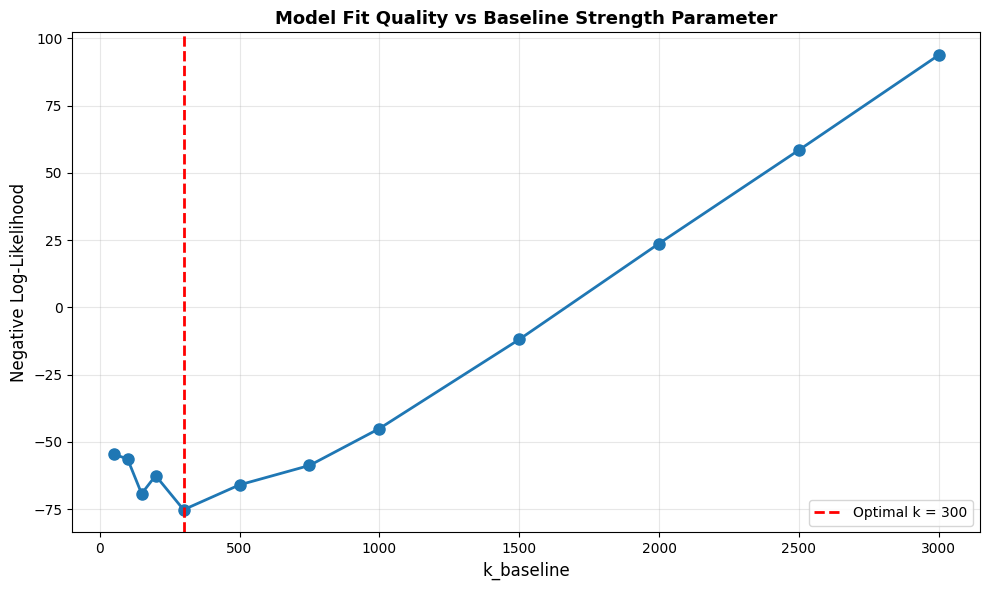

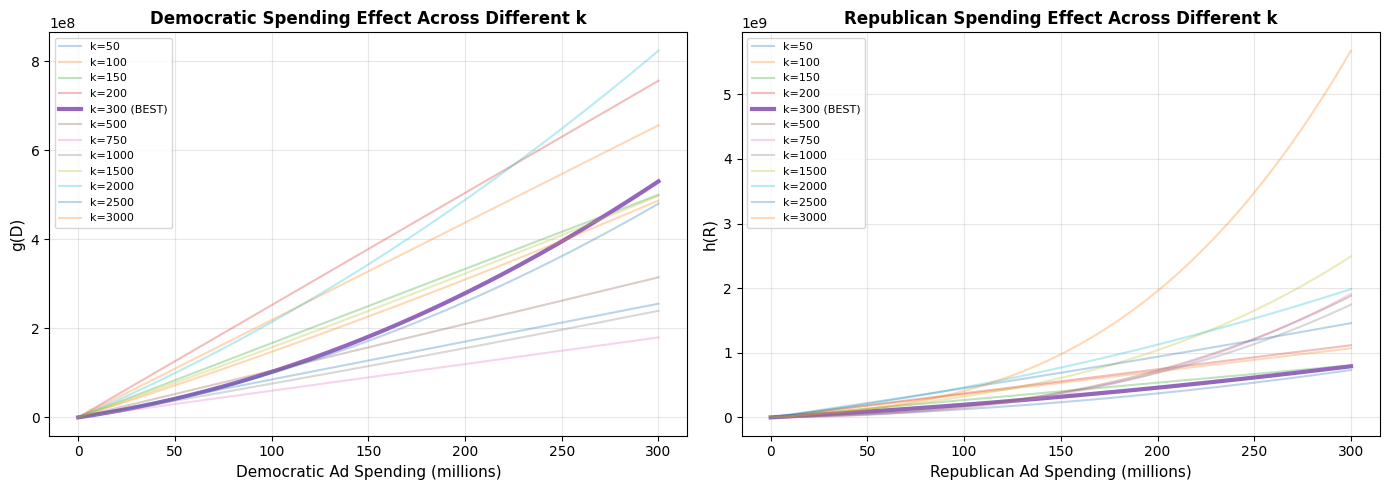


FINAL FIT WITH OPTIMAL k

Democratic spending effect g(D):
  g1   = 647742.2569898576
  g2   = 2550.7832677376405
  g3   = 0.0

Republican spending effect h(R):
  h1   = 1618085.851092574
  h2   = 1330.8202993500215
  h3   = 0.0

Optimal k_baseline = 300
Final neg log-likelihood: -76.4296

Model fit:
  Mean absolute error: 0.0286
  RMSE: 0.0328

PLOTTING OPTIMAL SPENDING EFFECT FUNCTIONS


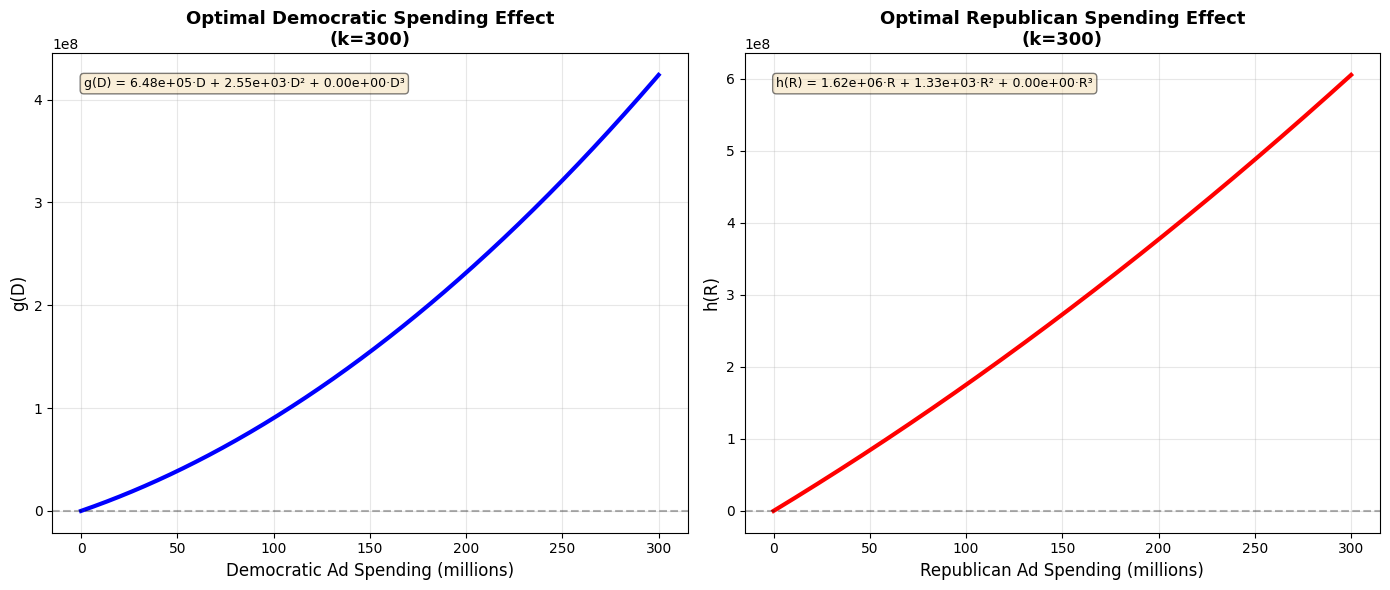


GENERATING STATE-BY-STATE BETA DISTRIBUTIONS


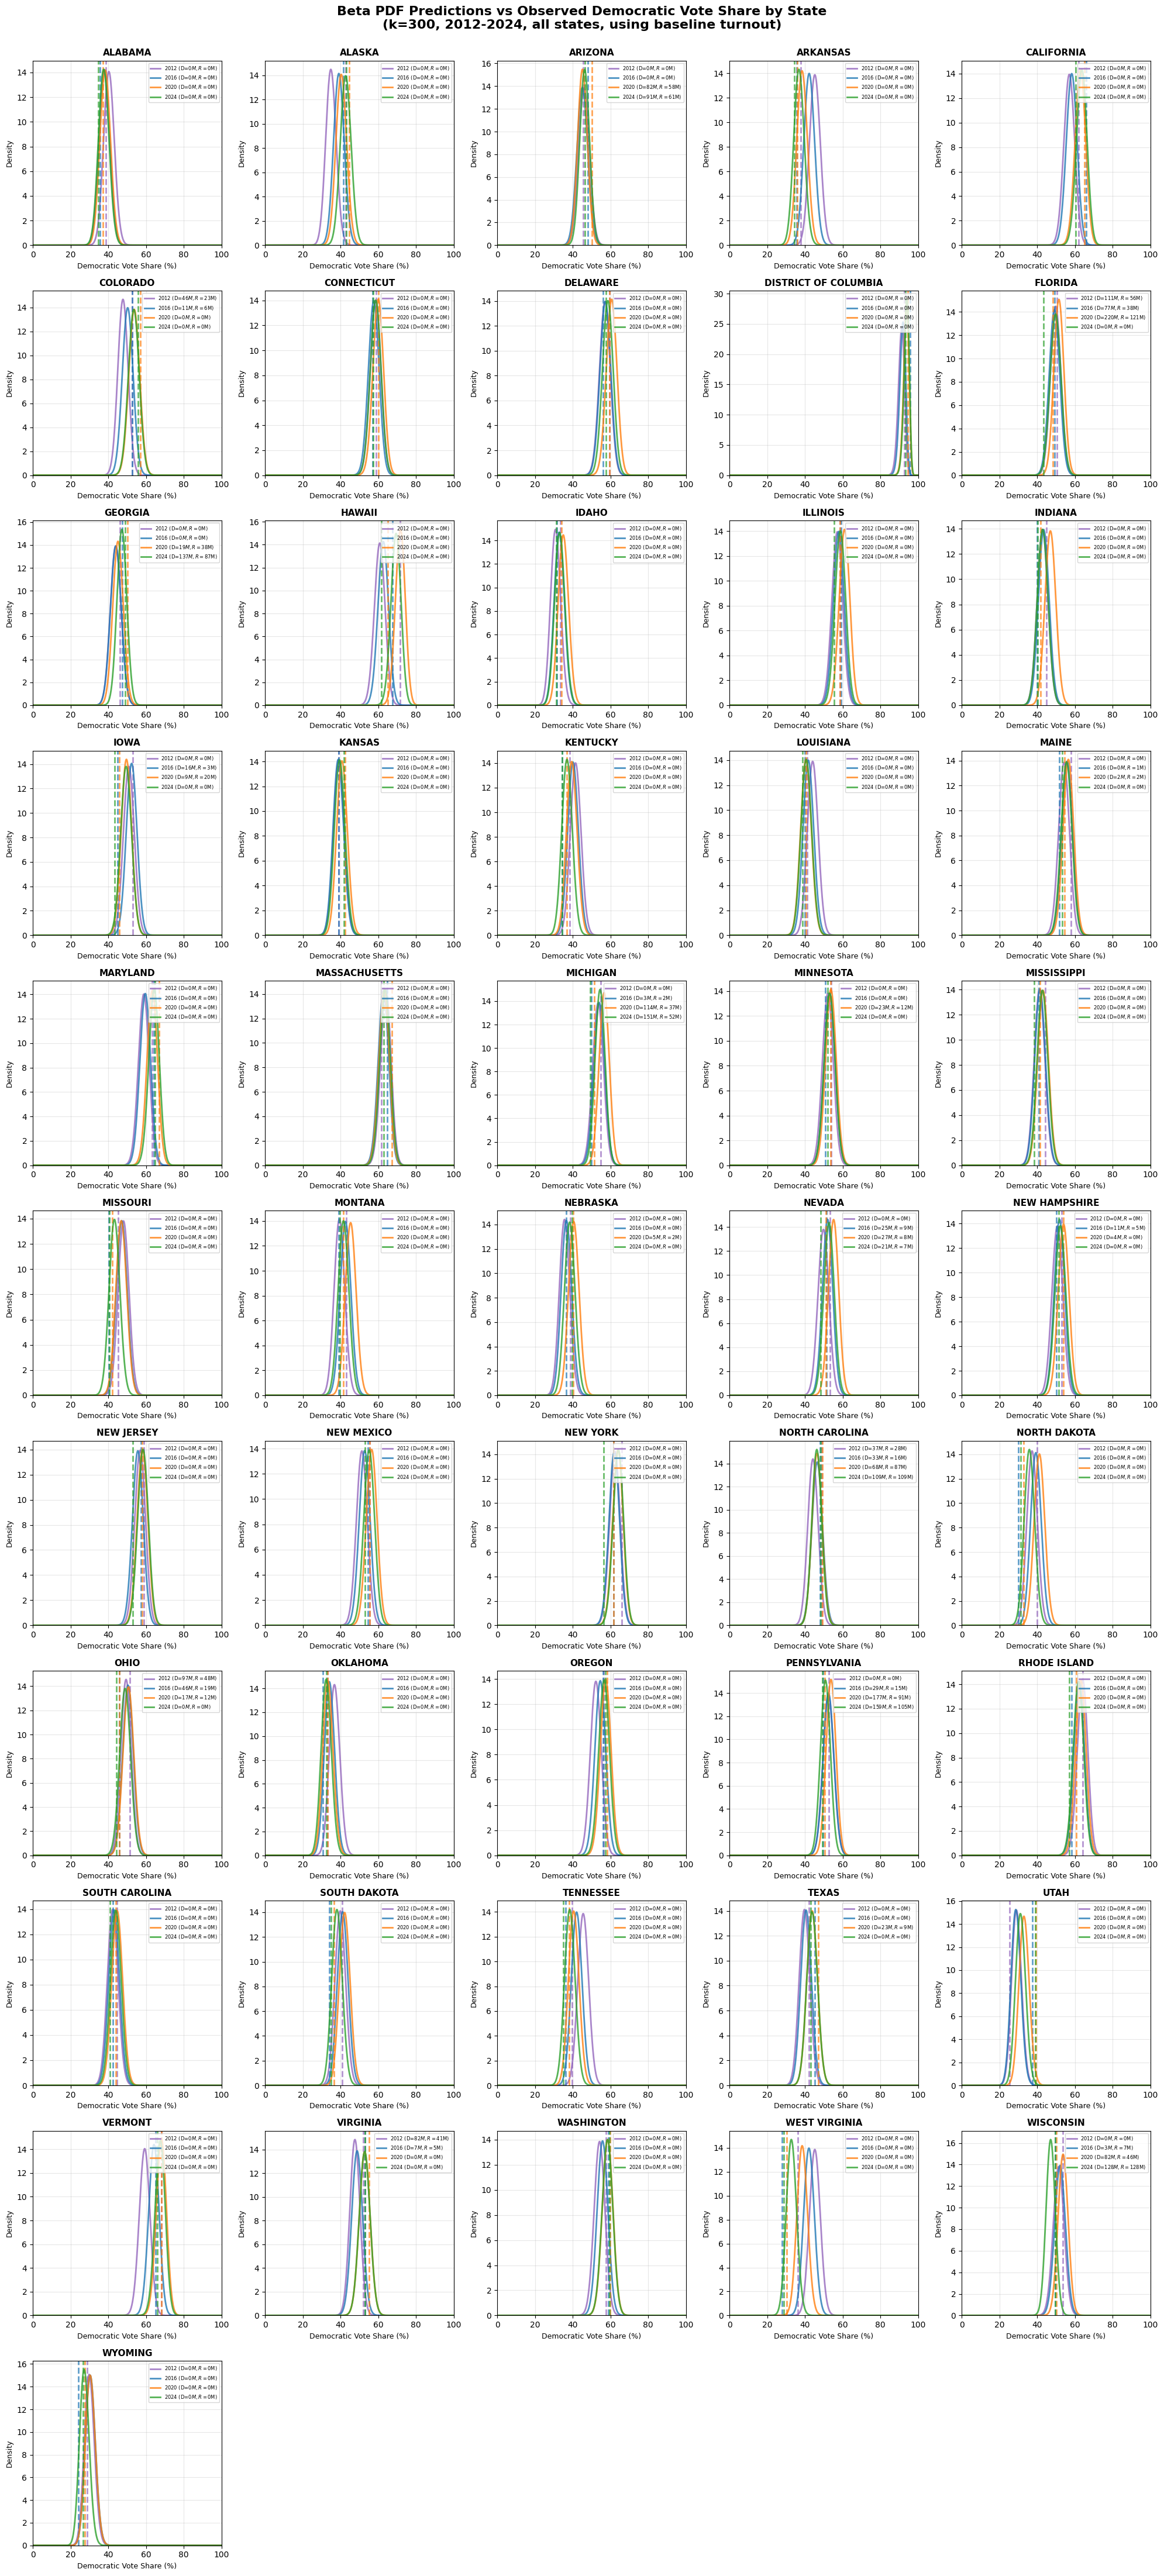


SENSITIVITY ANALYSIS: WYOMING, TEXAS, OHIO 2016

WYOMING: Baseline Pop=241,309, Baseline=0.306, Actual=0.243


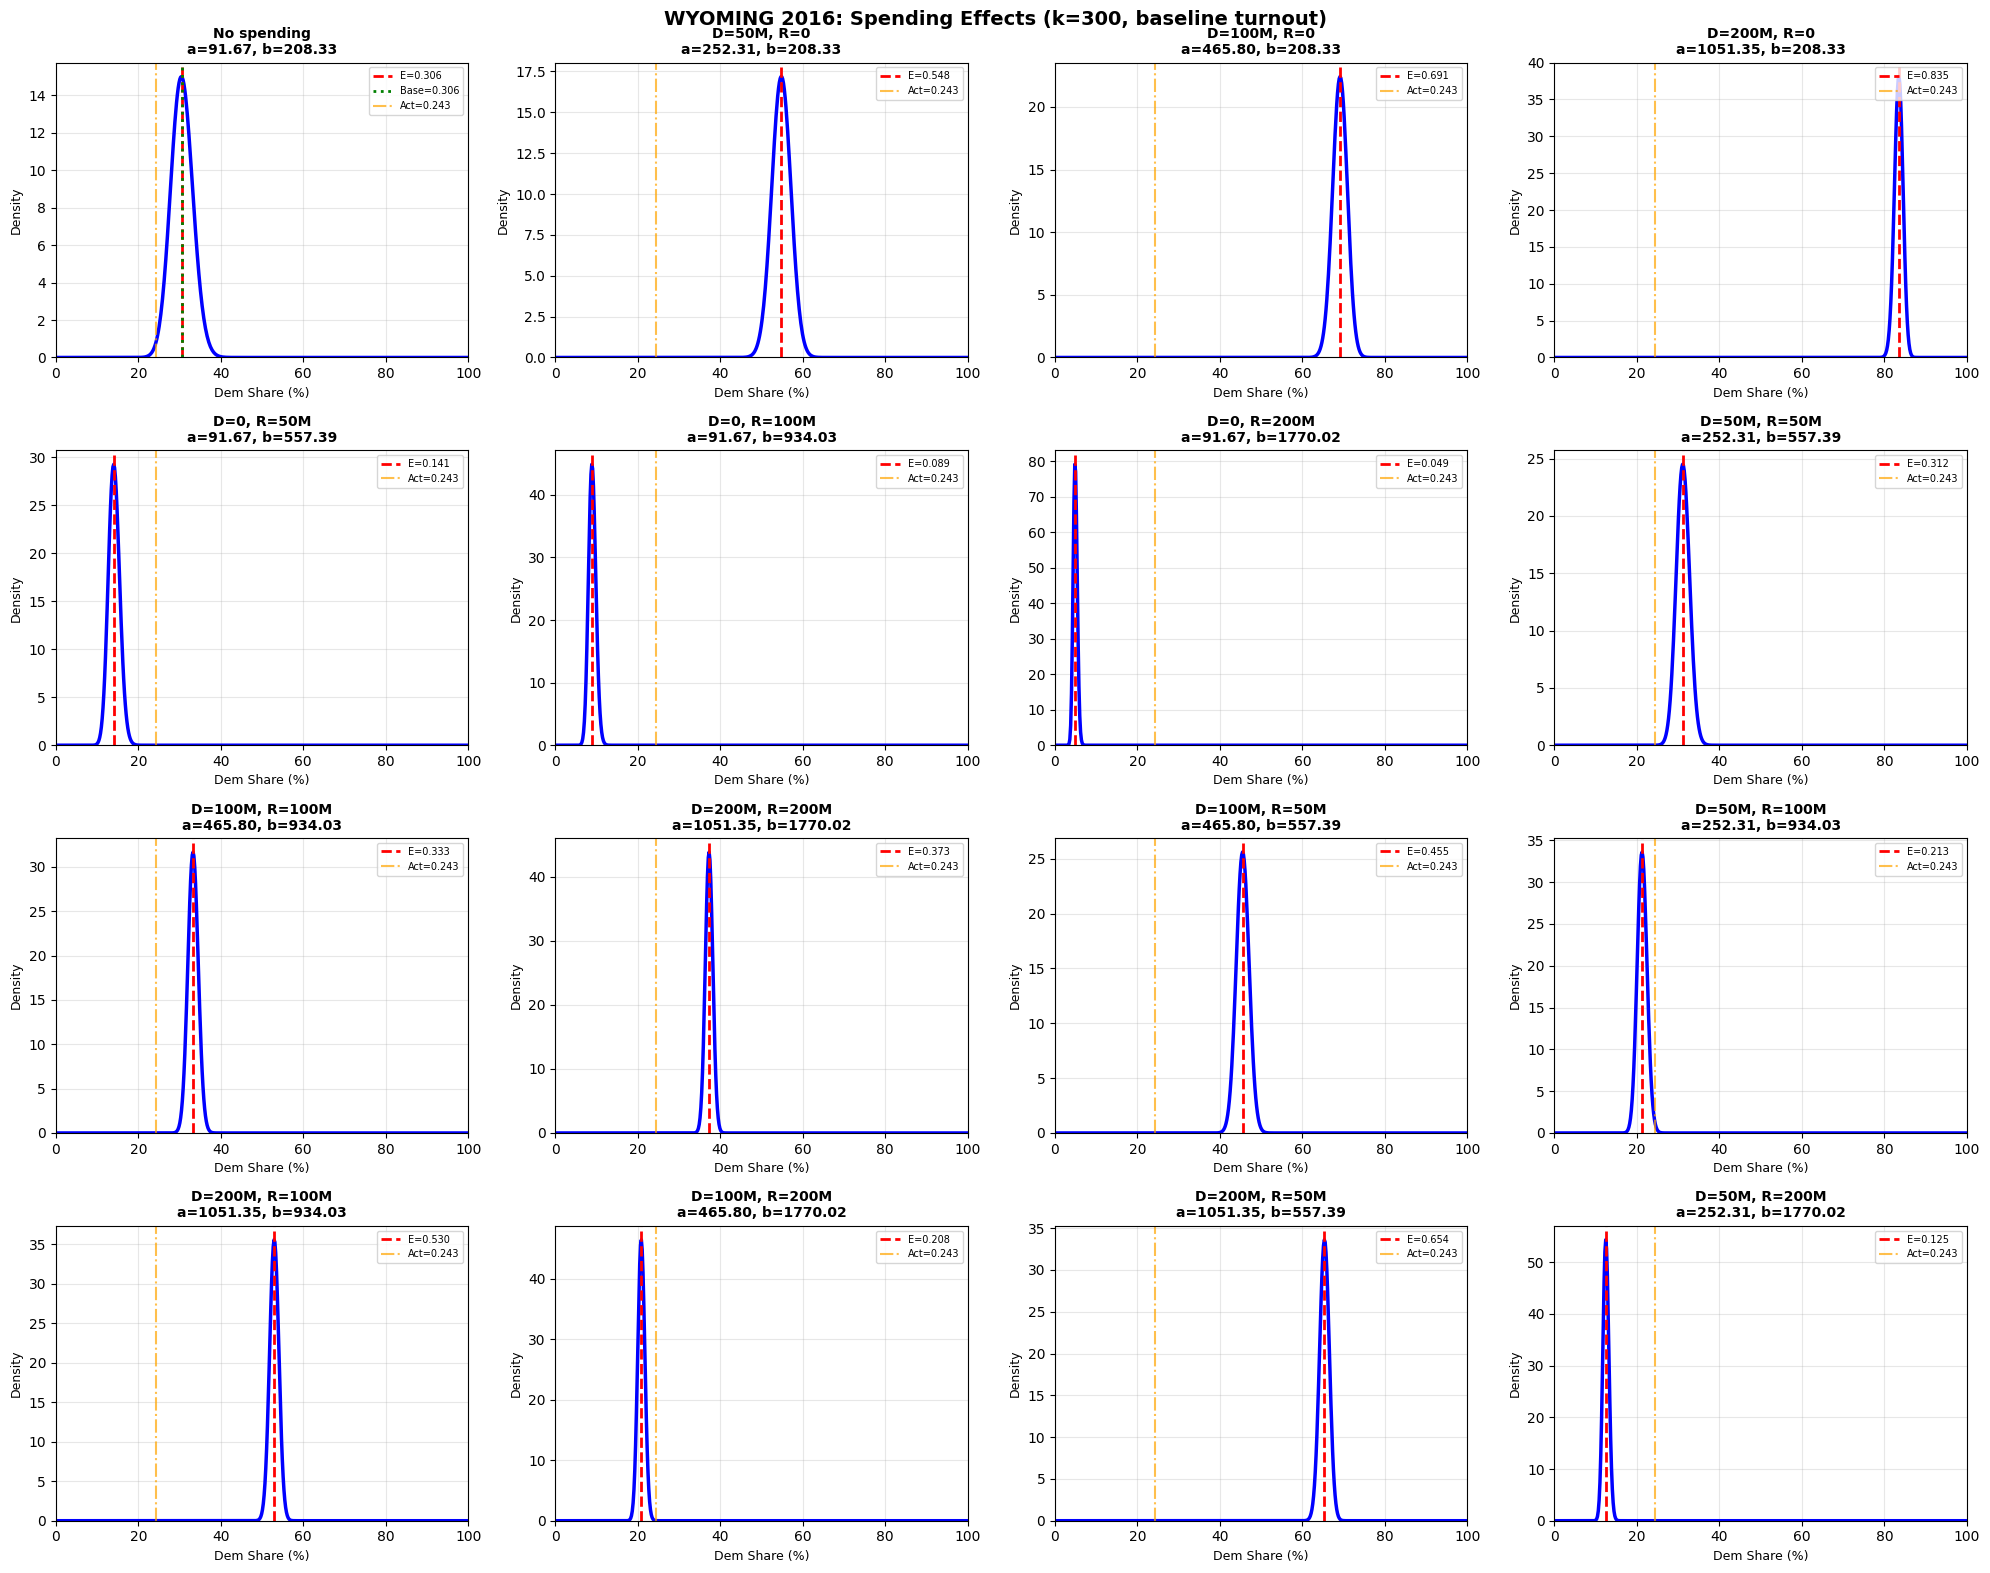


TEXAS: Baseline Pop=7,630,686, Baseline=0.406, Actual=0.453


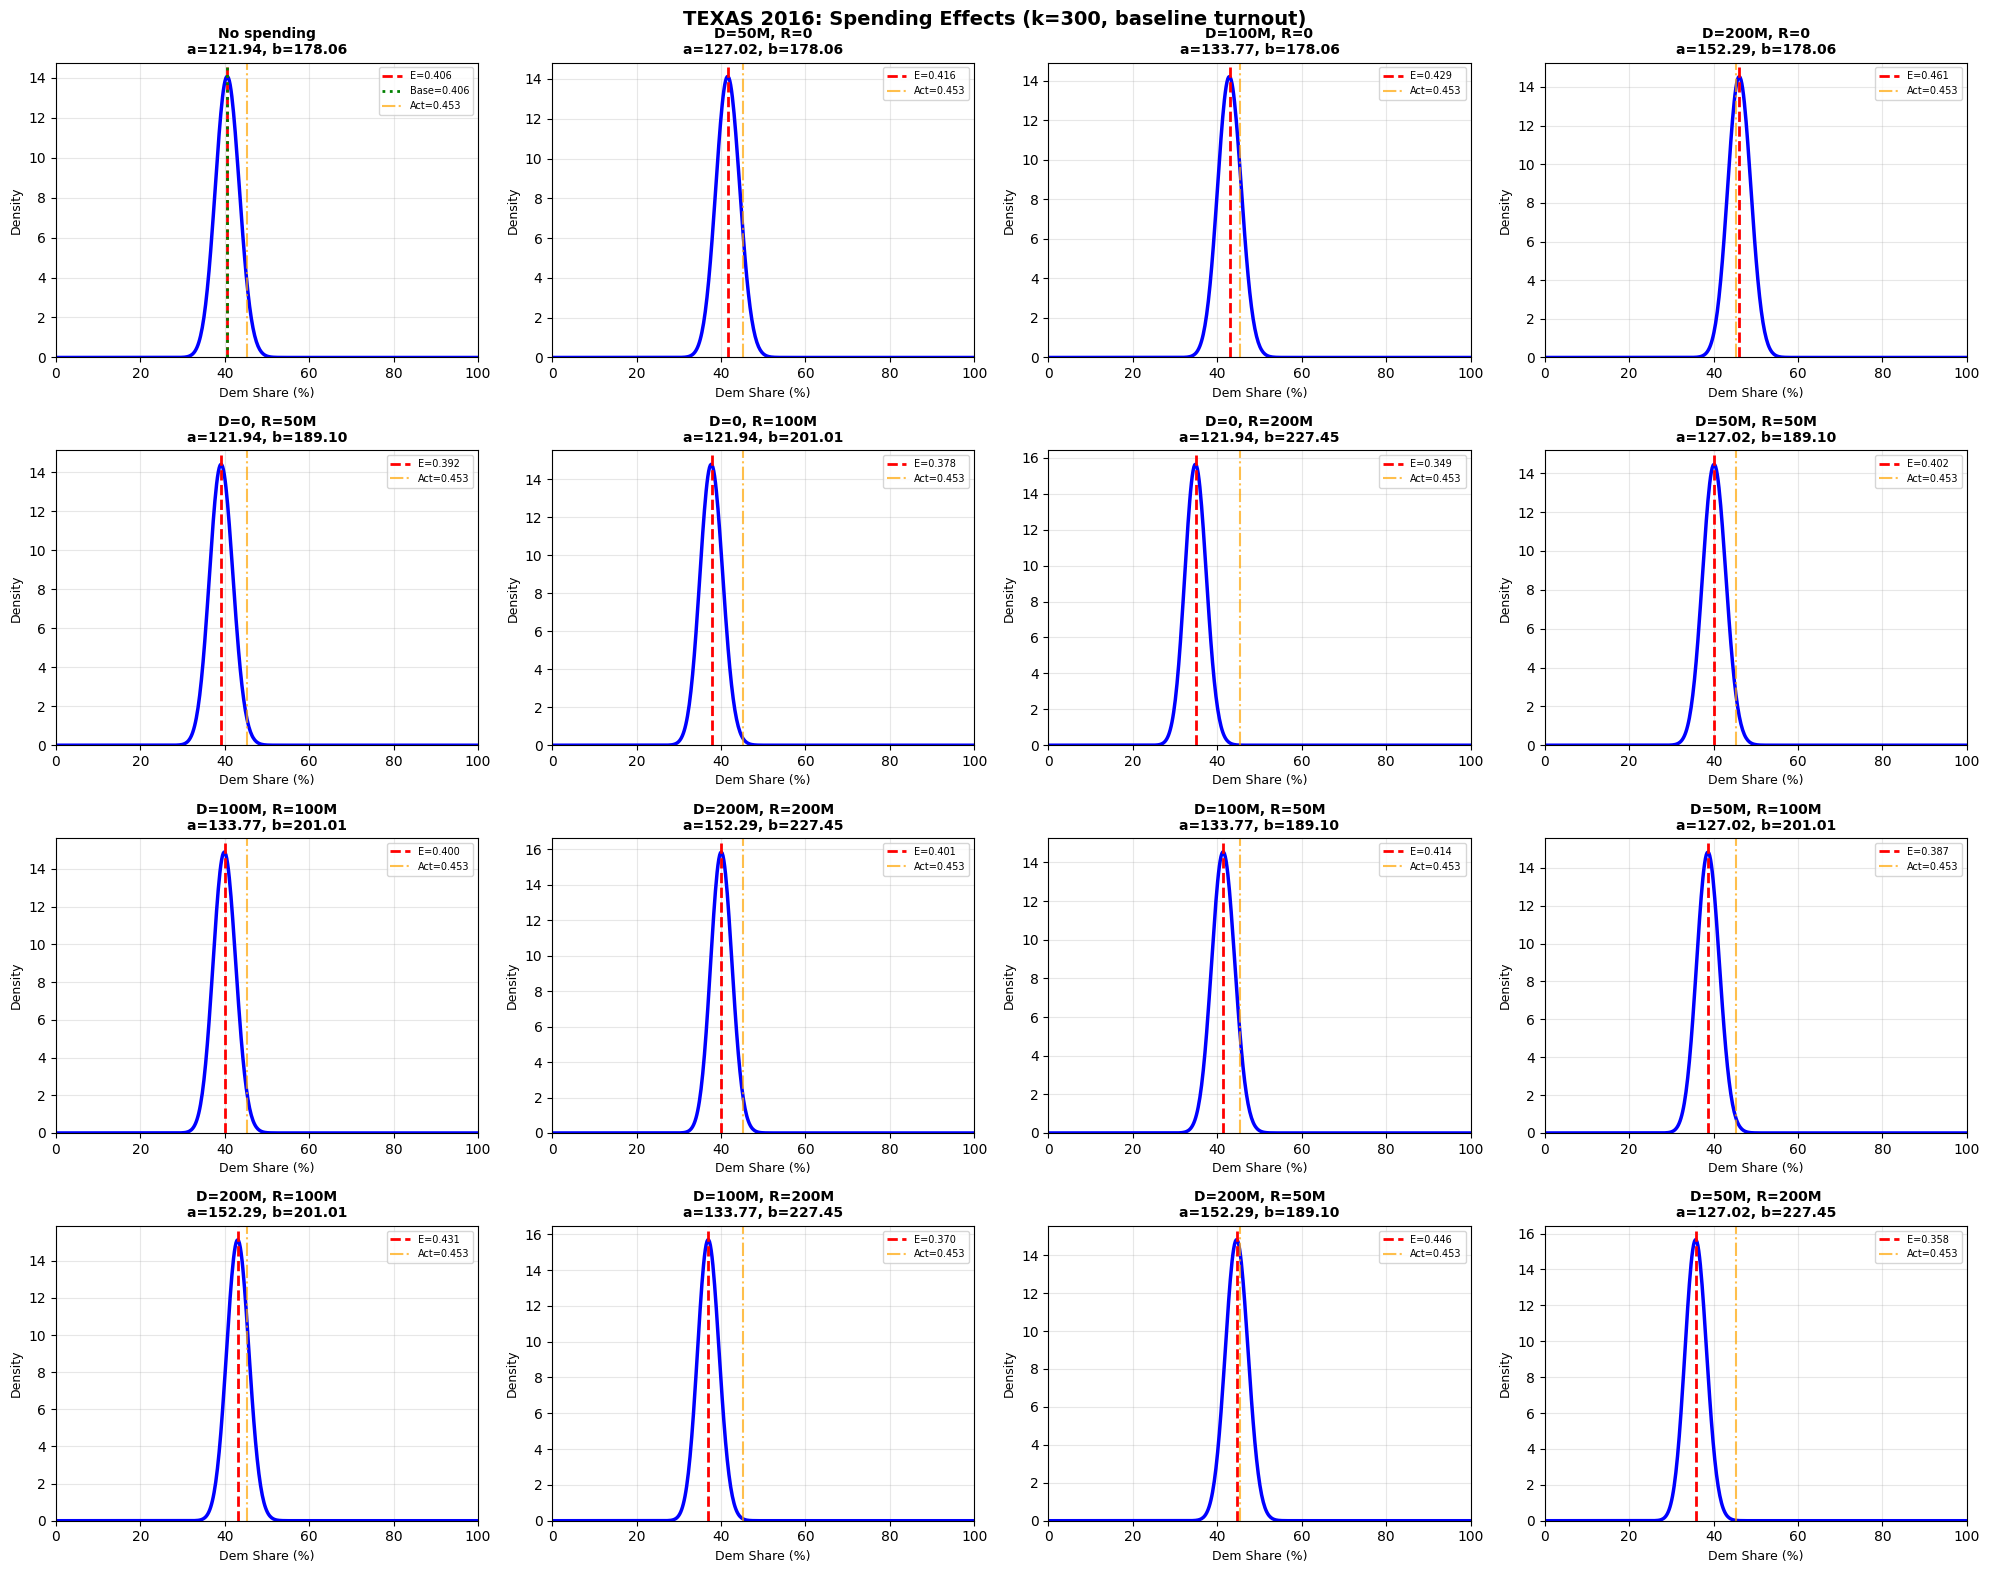


OHIO: Baseline Pop=5,581,252, Baseline=0.503, Actual=0.457


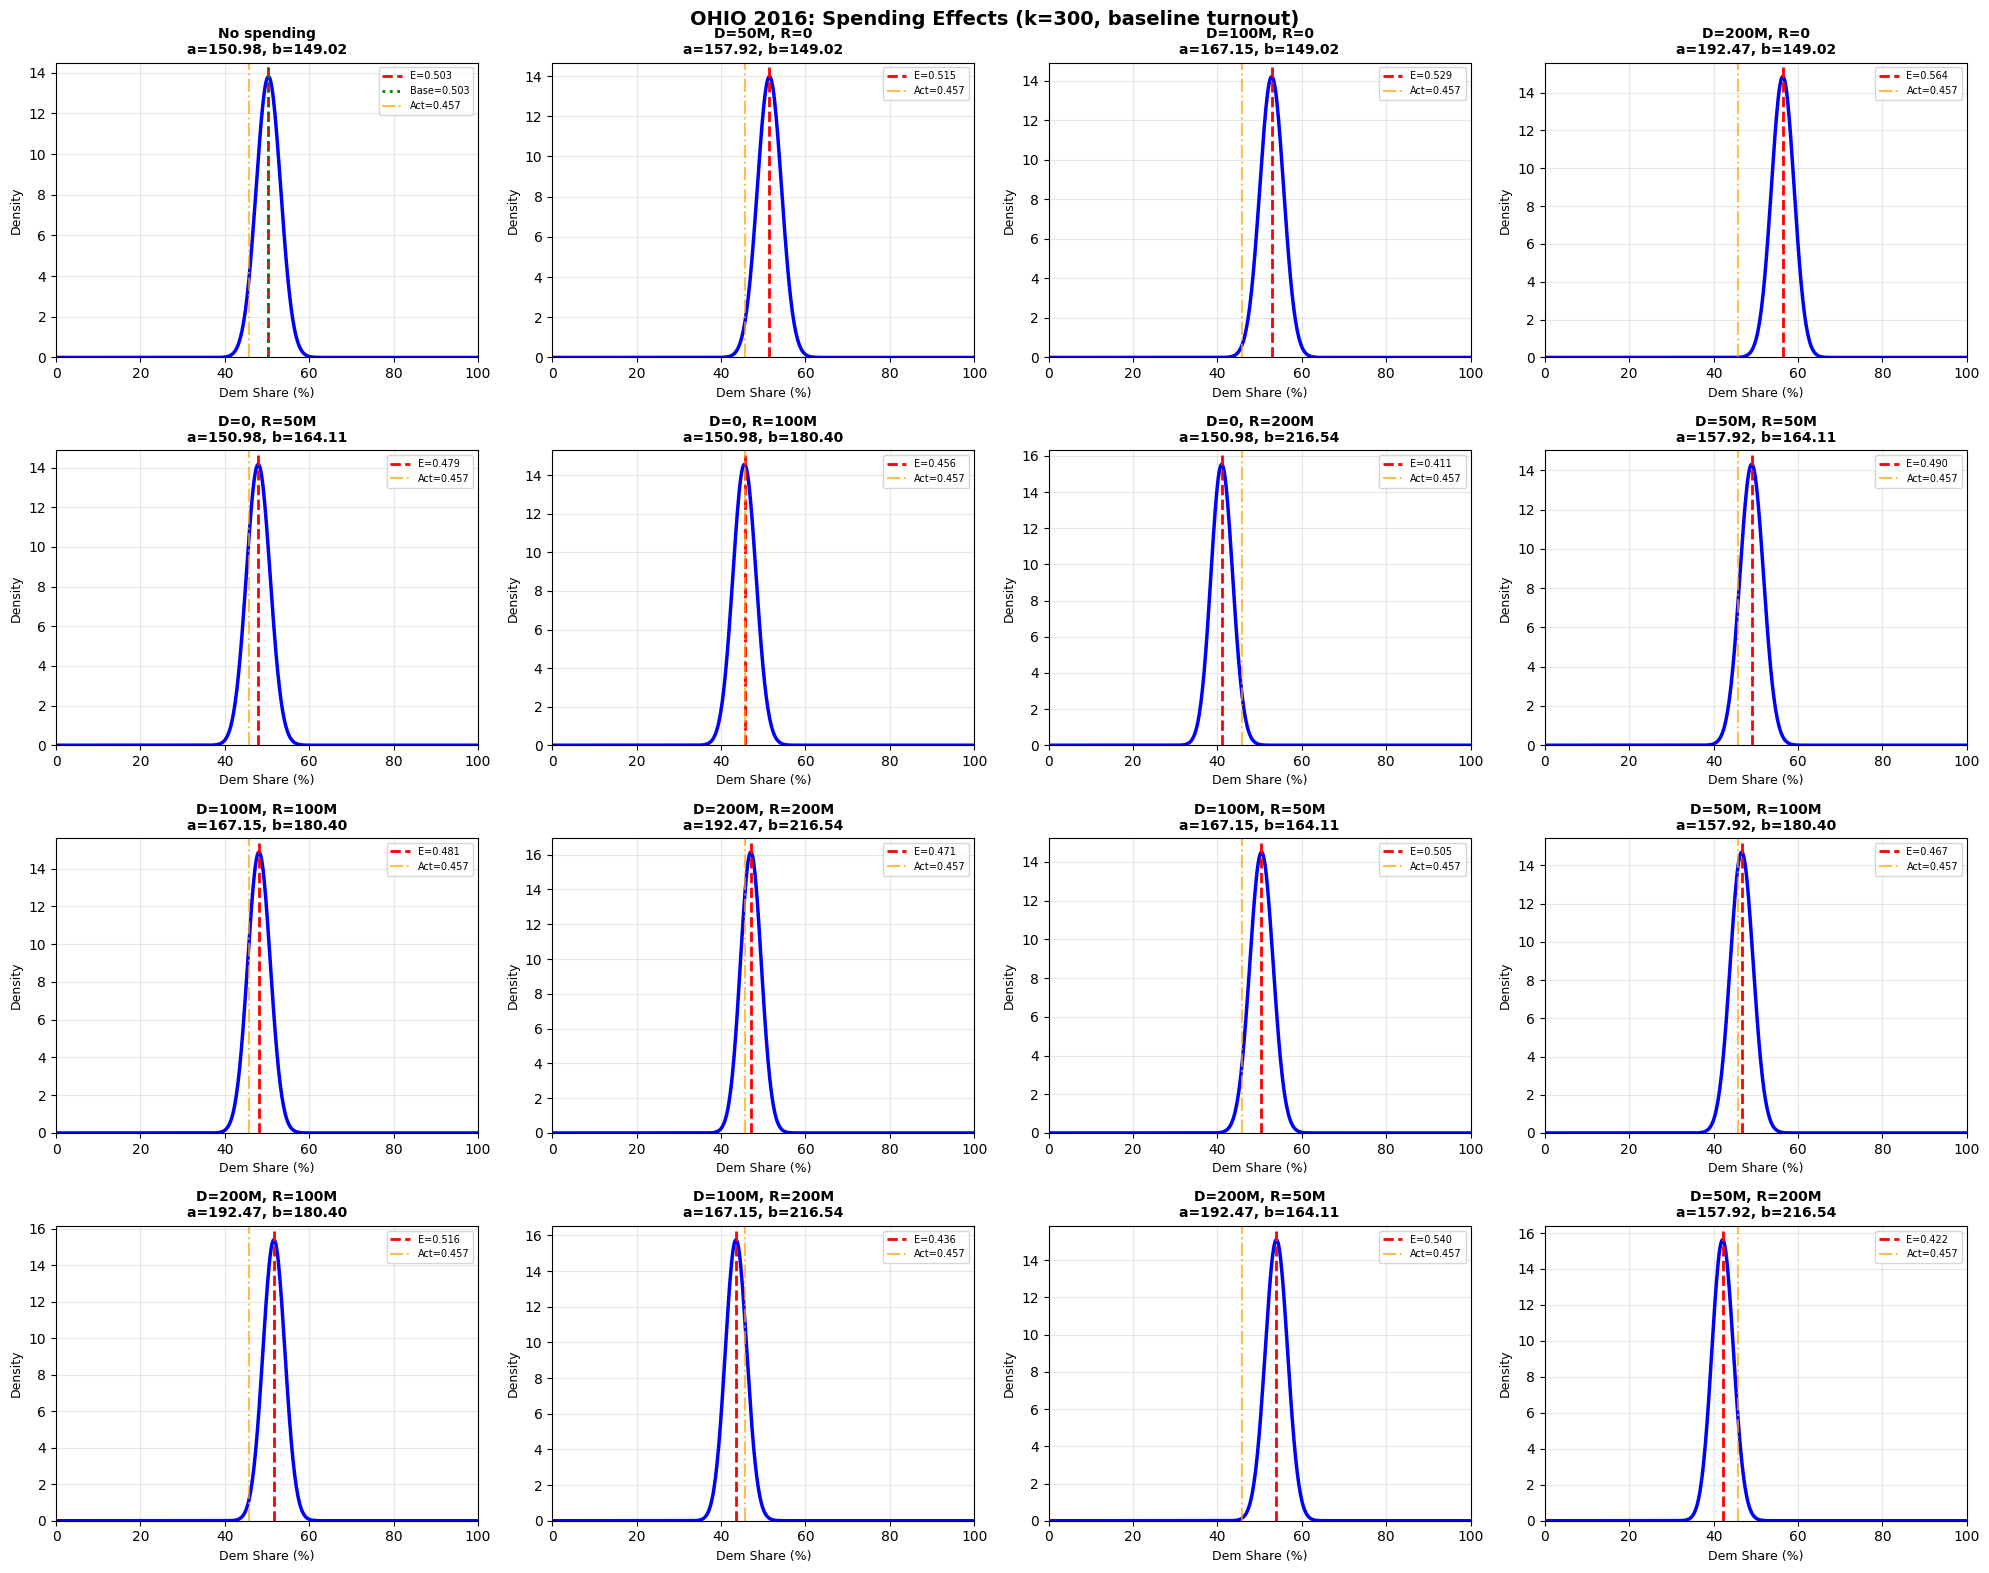


MODEL SUMMARY
Optimal k = 300
Use these fitted parameters for simulation:
  g(D) and h(R) functions with coefficients above
  N = Baseline_total_partisan (weighted avg of past 3 elections)


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from scipy.optimize import minimize

# Load data
county_df = pd.read_csv('countypres_2000-2024.csv')
ad_df = pd.read_csv('ad_data.csv')

# --- Calculate Democratic Vote Share by State and Year ---
state_partisan_votes = county_df[county_df['party'].isin(['DEMOCRAT', 'REPUBLICAN'])].groupby(
    ['year', 'state', 'party']
)['candidatevotes'].sum().unstack(fill_value=0).reset_index()

state_partisan_votes['DEM_SHARE'] = state_partisan_votes['DEMOCRAT'] / (
    state_partisan_votes['DEMOCRAT'] + state_partisan_votes['REPUBLICAN'])
state_partisan_votes['total_partisan'] = state_partisan_votes['DEMOCRAT'] + state_partisan_votes['REPUBLICAN']
state_partisan_votes = state_partisan_votes.sort_values(['state', 'year']).reset_index(drop=True)

# Calculate weighted 3-year prior Democratic share (baseline partisan lean)
def past_3_inverse_weights(series):
    s = series.shift(1)
    values = np.full(series.shape[0], np.nan)
    weights = np.array([1, 1/2, 1/3])
    for i in range(3, len(s)+1):
        window = s.iloc[i-3:i].values
        if np.isnan(window).any():
            continue
        weighted_avg = np.dot(window, weights) / np.sum(weights)
        values[i-1] = weighted_avg
    return pd.Series(values, index=series.index)

state_partisan_votes['Baseline_DEM_SHARE'] = (
    state_partisan_votes.groupby('state')['DEM_SHARE'].transform(past_3_inverse_weights)
)

# Calculate weighted 3-year prior total partisan votes (baseline turnout)
state_partisan_votes['Baseline_total_partisan'] = (
    state_partisan_votes.groupby('state')['total_partisan'].transform(past_3_inverse_weights)
)

# Standardize state names
state_partisan_votes['state'] = state_partisan_votes['state'].str.upper()
ad_df['State'] = ad_df['State'].str.upper()

# Merge with ad spending
combined_data = ad_df.merge(
    state_partisan_votes[['year', 'state', 'total_partisan', 'DEM_SHARE', 'Baseline_DEM_SHARE', 'Baseline_total_partisan']],
    left_on=['year', 'State'],
    right_on=['year', 'state'],
    how='inner'
)

# Filter out Iowa 2016
combined_data = combined_data[~((combined_data['State'] == 'IOWA') & (combined_data['year'] == 2016))]
combined_data = combined_data.dropna(subset=['D-ad-spending', 'R-ad-spending', 'DEM_SHARE', 'total_partisan', 'Baseline_DEM_SHARE', 'Baseline_total_partisan'])

eps = 1e-7

# === Define model functions ===
def g(D, g1, g2, g3):
    """Democratic spending effect - g(0) = 0"""
    return g1 * D + g2 * D**2 + g3 * D**3

def h(R, h1, h2, h3):
    """Republican spending effect - h(0) = 0"""
    return h1 * R + h2 * R**2 + h3 * R**3

def neg_log_likelihood(params, D_spending, R_spending, dem_share_clipped, baseline_total_partisan, p_D_fixed, p_R_fixed):
    """Negative log-likelihood for optimization - NOW USES BASELINE TURNOUT"""
    g1, g2, g3 = params[0:3]
    h1, h2, h3 = params[3:6]
    
    if np.any(np.array([g1, g2, g3, h1, h2, h3]) < 0):
        return 1e12
    
    g_vals = g(D_spending, g1, g2, g3)
    h_vals = h(R_spending, h1, h2, h3)
    
    # KEY CHANGE: Use baseline_total_partisan instead of actual total_partisan
    a_vals = (1.0 / baseline_total_partisan) * g_vals + p_D_fixed
    b_vals = (1.0 / baseline_total_partisan) * h_vals + p_R_fixed
    
    if np.any(a_vals <= 0) or np.any(b_vals <= 0):
        return 1e12
    
    ll = np.sum(beta.logpdf(dem_share_clipped, a_vals, b_vals))
    return -ll

# Initial parameters and bounds
initial_params = np.array([5e5, 1e3, 10, 5e5, 1e3, 10])

bounds = [
    (0, None), (0, None), (0, None),  # g
    (0, None), (0, None), (0, None),  # h
]

# === PARAMETER SEARCH FOR OPTIMAL k_baseline ===
print("\n" + "="*80)
print("SEARCHING FOR OPTIMAL k_baseline WITH MULTIPLE INITIALIZATIONS")
print("="*80)

k_values = [50, 100, 150, 200, 300, 500, 750, 1000, 1500, 2000, 2500, 3000]
results_by_k = []

n_random_starts = 50  # Try 50 different random initializations per k

for k_baseline in k_values:
    print(f"\nTrying k_baseline = {k_baseline}...")
    
    combined_data['p_D'] = k_baseline * combined_data['Baseline_DEM_SHARE']
    combined_data['p_R'] = k_baseline * (1 - combined_data['Baseline_DEM_SHARE'])
    
    D_spending = combined_data['D-ad-spending'].values
    R_spending = combined_data['R-ad-spending'].values
    dem_share = combined_data['DEM_SHARE'].values
    baseline_total_partisan = combined_data['Baseline_total_partisan'].values  # CHANGED
    p_D_fixed = combined_data['p_D'].values
    p_R_fixed = combined_data['p_R'].values
    dem_share_clipped = np.clip(dem_share, eps, 1 - eps)
    
    best_nll = np.inf
    best_params_for_k = None
    best_success = False
    
    # Try multiple random initializations
    for i in range(n_random_starts):
        random_init = np.array([
            np.random.uniform(1e4, 1e7),  # g1
            np.random.uniform(0, 1e4),    # g2
            np.random.uniform(0, 1e3),    # g3
            np.random.uniform(1e4, 1e7),  # h1
            np.random.uniform(0, 1e4),    # h2
            np.random.uniform(0, 1e3),    # h3
        ])
        
        result_k = minimize(
            lambda p: neg_log_likelihood(p, D_spending, R_spending, dem_share_clipped, baseline_total_partisan, p_D_fixed, p_R_fixed),
            random_init, bounds=bounds, method='L-BFGS-B', options={'maxiter': 1000, 'ftol': 1e-8}
        )
        
        if result_k.success and result_k.fun < best_nll:
            best_nll = result_k.fun
            best_params_for_k = result_k.x.copy()
            best_success = True
    
    results_by_k.append({
        'k_baseline': k_baseline,
        'neg_log_likelihood': best_nll,
        'success': best_success,
        'params': best_params_for_k
    })
    
    print(f"  Best Neg Log-Likelihood: {best_nll:.4f} (from {n_random_starts} random starts)")

# Find best k
results_df = pd.DataFrame(results_by_k)
best_idx = results_df['neg_log_likelihood'].idxmin()
best_k = results_df.loc[best_idx, 'k_baseline']
best_params = results_df.loc[best_idx, 'params']

print("\n" + "="*80)
print("k_baseline SEARCH RESULTS")
print("="*80)
print(results_df[['k_baseline', 'neg_log_likelihood', 'success']].to_string(index=False))
print(f"\nOPTIMAL k_baseline = {best_k}")

# Plot likelihood vs k
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(results_df['k_baseline'], results_df['neg_log_likelihood'], 'o-', lw=2, markersize=8)
ax.axvline(best_k, color='r', linestyle='--', lw=2, label=f'Optimal k = {best_k}')
ax.set_xlabel('k_baseline', fontsize=12)
ax.set_ylabel('Negative Log-Likelihood', fontsize=12)
ax.set_title('Model Fit Quality vs Baseline Strength Parameter', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot spending effect curves for different k values
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

D_range_viz = np.linspace(0, 300, 200)  # 0 to 300M spending
R_range_viz = np.linspace(0, 300, 200)

for i, row in results_df.iterrows():
    if row['success'] and row['params'] is not None:
        k_val = row['k_baseline']
        params = row['params']
        g1, g2, g3 = params[0:3]
        h1, h2, h3 = params[3:6]
        
        g_curve = g(D_range_viz, g1, g2, g3)
        h_curve = h(R_range_viz, h1, h2, h3)
        
        alpha = 0.3 if k_val != best_k else 1.0
        lw = 1.5 if k_val != best_k else 3.0
        label = f'k={k_val}' + (' (BEST)' if k_val == best_k else '')
        
        axes[0].plot(D_range_viz, g_curve, alpha=alpha, lw=lw, label=label)
        axes[1].plot(R_range_viz, h_curve, alpha=alpha, lw=lw, label=label, color=f'C{i}')

axes[0].set_xlabel('Democratic Ad Spending (millions)', fontsize=11)
axes[0].set_ylabel('g(D)', fontsize=11)
axes[0].set_title('Democratic Spending Effect Across Different k', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=8)
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Republican Ad Spending (millions)', fontsize=11)
axes[1].set_ylabel('h(R)', fontsize=11)
axes[1].set_title('Republican Spending Effect Across Different k', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=8)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# === FIT FINAL MODEL WITH OPTIMAL k ===
k_baseline = best_k
combined_data['p_D'] = k_baseline * combined_data['Baseline_DEM_SHARE']
combined_data['p_R'] = k_baseline * (1 - combined_data['Baseline_DEM_SHARE'])

D_spending = combined_data['D-ad-spending'].values
R_spending = combined_data['R-ad-spending'].values
dem_share = combined_data['DEM_SHARE'].values
baseline_total_partisan = combined_data['Baseline_total_partisan'].values  # CHANGED
p_D_fixed = combined_data['p_D'].values
p_R_fixed = combined_data['p_R'].values
dem_share_clipped = np.clip(dem_share, eps, 1 - eps)

print("\n" + "="*80)
print("FINAL FIT WITH OPTIMAL k")
print("="*80)

result = minimize(
    lambda p: neg_log_likelihood(p, D_spending, R_spending, dem_share_clipped, baseline_total_partisan, p_D_fixed, p_R_fixed),
    best_params, bounds=bounds, method='L-BFGS-B', options={'maxiter': 2000, 'ftol': 1e-9}
)

g1_opt, g2_opt, g3_opt = result.x[0:3]
h1_opt, h2_opt, h3_opt = result.x[3:6]

print(f"\nDemocratic spending effect g(D):")
print(f"  g1   = {g1_opt}")
print(f"  g2   = {g2_opt}")
print(f"  g3   = {g3_opt}")

print(f"\nRepublican spending effect h(R):")
print(f"  h1   = {h1_opt}")
print(f"  h2   = {h2_opt}")
print(f"  h3   = {h3_opt}")

print(f"\nOptimal k_baseline = {k_baseline}")
print(f"Final neg log-likelihood: {result.fun:.4f}")

# Calculate fitted values for diagnostics
g_vals_fitted = g(D_spending, g1_opt, g2_opt, g3_opt)
h_vals_fitted = h(R_spending, h1_opt, h2_opt, h3_opt)
a_fitted = (1.0 / baseline_total_partisan) * g_vals_fitted + p_D_fixed
b_fitted = (1.0 / baseline_total_partisan) * h_vals_fitted + p_R_fixed
predicted_share = a_fitted / (a_fitted + b_fitted)

residuals = dem_share - predicted_share
print(f"\nModel fit:")
print(f"  Mean absolute error: {np.mean(np.abs(residuals)):.4f}")
print(f"  RMSE: {np.sqrt(np.mean(residuals**2)):.4f}")

# === PLOT FINAL OPTIMAL g(D) AND h(R) FUNCTIONS ===
print("\n" + "="*80)
print("PLOTTING OPTIMAL SPENDING EFFECT FUNCTIONS")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

D_range_final = np.linspace(0, 300, 500)
R_range_final = np.linspace(0, 300, 500)

g_final = g(D_range_final, g1_opt, g2_opt, g3_opt)
h_final = h(R_range_final, h1_opt, h2_opt, h3_opt)

axes[0].plot(D_range_final, g_final, 'b-', lw=3)
axes[0].set_xlabel('Democratic Ad Spending (millions)', fontsize=12)
axes[0].set_ylabel('g(D)', fontsize=12)
axes[0].set_title(f'Optimal Democratic Spending Effect\n(k={k_baseline})', 
                  fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(0, color='k', linestyle='--', alpha=0.3)

g_text = (f"g(D) = {g1_opt:.2e}·D + {g2_opt:.2e}·D² + {g3_opt:.2e}·D³")
axes[0].text(0.05, 0.95, g_text, transform=axes[0].transAxes,
            fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

axes[1].plot(R_range_final, h_final, 'r-', lw=3)
axes[1].set_xlabel('Republican Ad Spending (millions)', fontsize=12)
axes[1].set_ylabel('h(R)', fontsize=12)
axes[1].set_title(f'Optimal Republican Spending Effect\n(k={k_baseline})', 
                  fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(0, color='k', linestyle='--', alpha=0.3)

h_text = (f"h(R) = {h1_opt:.2e}·R + {h2_opt:.2e}·R² + {h3_opt:.2e}·R³")
axes[1].text(0.05, 0.95, h_text, transform=axes[1].transAxes,
            fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# === PLOT ALL 51 STATE DISTRIBUTIONS FOR 2012-2024 ===
print("\n" + "="*80)
print("GENERATING STATE-BY-STATE BETA DISTRIBUTIONS")
print("="*80)

# Prepare all states data
all_state_votes = state_partisan_votes.copy()
all_state_votes['p_D'] = k_baseline * all_state_votes['Baseline_DEM_SHARE']
all_state_votes['p_R'] = k_baseline * (1 - all_state_votes['Baseline_DEM_SHARE'])

all_states_data = all_state_votes.merge(
    ad_df[['year', 'State', 'D-ad-spending', 'R-ad-spending']],
    left_on=['year', 'state'], right_on=['year', 'State'], how='left'
)
all_states_data['D-ad-spending'] = all_states_data['D-ad-spending'].fillna(0)
all_states_data['R-ad-spending'] = all_states_data['R-ad-spending'].fillna(0)

years_to_plot = [2012, 2016, 2020, 2024]
plot_data = all_states_data[all_states_data['year'].isin(years_to_plot)].copy()
plot_data = plot_data.dropna(subset=['p_D', 'p_R', 'Baseline_total_partisan'])

# Calculate a and b for each state-year using BASELINE turnout
D_plot = plot_data['D-ad-spending'].values
R_plot = plot_data['R-ad-spending'].values
N_plot = plot_data['Baseline_total_partisan'].values  # CHANGED
p_D_plot = plot_data['p_D'].values
p_R_plot = plot_data['p_R'].values

g_plot = g(D_plot, g1_opt, g2_opt, g3_opt)
h_plot = h(R_plot, h1_opt, h2_opt, h3_opt)

plot_data['a'] = (1.0 / N_plot) * g_plot + p_D_plot
plot_data['b'] = (1.0 / N_plot) * h_plot + p_R_plot

# Create state plots
unique_plot_states = sorted(plot_data['state'].unique())
n_plot_states = len(unique_plot_states)
n_cols = 5
n_rows = (n_plot_states + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

x_range = np.linspace(0, 1, 500)
year_colors = {2012: '#9467bd', 2016: '#1f77b4', 2020: '#ff7f0e', 2024: '#2ca02c'}

for idx, state in enumerate(unique_plot_states):
    ax = axes[idx]
    state_entries = plot_data[plot_data['state'] == state]
    
    for _, row in state_entries.iterrows():
        a_val = row['a']
        b_val = row['b']
        dem_share_actual = row['DEM_SHARE']
        year = int(row['year'])
        d_spend = row['D-ad-spending']
        r_spend = row['R-ad-spending']
        color = year_colors.get(year, 'gray')
        
        pdf_vals = beta.pdf(x_range, a_val, b_val)
        
        ax.plot(x_range * 100, pdf_vals, linewidth=2, color=color,
                label=f'{year} (D=${d_spend:.0f}M, R=${r_spend:.0f}M)', alpha=0.8)
        
        ax.axvline(x=dem_share_actual * 100, linestyle='--', linewidth=2,
                   alpha=0.7, color=color)
    
    ax.set_xlim(0, 100)
    ax.set_ylim(bottom=0)
    ax.set_xlabel('Democratic Vote Share (%)', fontsize=9)
    ax.set_ylabel('Density', fontsize=9)
    ax.set_title(f'{state}', fontsize=11, fontweight='bold')
    ax.legend(fontsize=6, loc='upper right')
    ax.grid(True, alpha=0.3)

for idx in range(n_plot_states, len(axes)):
    axes[idx].axis('off')

plt.suptitle(
    f'Beta PDF Predictions vs Observed Democratic Vote Share by State\n'
    f'(k={k_baseline}, 2012-2024, all states, using baseline turnout)',
    fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# === SENSITIVITY ANALYSIS FOR WYOMING, TEXAS, OHIO 2016 ===
print("\n" + "="*80)
print("SENSITIVITY ANALYSIS: WYOMING, TEXAS, OHIO 2016")
print("="*80)

test_scenarios = [
    (0, 0, "No spending"), (50, 0, "D=50M, R=0"), (100, 0, "D=100M, R=0"), (200, 0, "D=200M, R=0"),
    (0, 50, "D=0, R=50M"), (0, 100, "D=0, R=100M"), (0, 200, "D=0, R=200M"),
    (50, 50, "D=50M, R=50M"), (100, 100, "D=100M, R=100M"), (200, 200, "D=200M, R=200M"),
    (100, 50, "D=100M, R=50M"), (50, 100, "D=50M, R=100M"), (200, 100, "D=200M, R=100M"),
    (100, 200, "D=100M, R=200M"), (200, 50, "D=200M, R=50M"), (50, 200, "D=50M, R=200M"),
]

for state_name in ['WYOMING', 'TEXAS', 'OHIO']:
    state_data = all_states_data[(all_states_data['state'] == state_name) & (all_states_data['year'] == 2016)]
    
    if len(state_data) == 0:
        print(f"\n{state_name} 2016 data not found, skipping...")
        continue
    
    state_row = state_data.iloc[0]
    N_state = state_row['Baseline_total_partisan']  # CHANGED
    p_D_state = state_row['p_D']
    p_R_state = state_row['p_R']
    actual_dem_share = state_row['DEM_SHARE']
    baseline_dem_share = state_row['Baseline_DEM_SHARE']
    
    print(f"\n{state_name}: Baseline Pop={N_state:,.0f}, Baseline={baseline_dem_share:.3f}, Actual={actual_dem_share:.3f}")
    
    fig, axes = plt.subplots(4, 4, figsize=(20, 16))
    axes = axes.flatten()
    x_range = np.linspace(0, 1, 500)
    
    for idx, (D_test, R_test, label) in enumerate(test_scenarios):
        ax = axes[idx]
        
        g_val = g(D_test, g1_opt, g2_opt, g3_opt)
        h_val = h(R_test, h1_opt, h2_opt, h3_opt)
        
        a_test = (1.0 / N_state) * g_val + p_D_state
        b_test = (1.0 / N_state) * h_val + p_R_state
        expected_share = a_test / (a_test + b_test)
        
        pdf_vals = beta.pdf(x_range, a_test, b_test)
        ax.plot(x_range * 100, pdf_vals, 'b-', lw=2.5)
        ax.axvline(expected_share * 100, color='r', linestyle='--', lw=2, label=f'E={expected_share:.3f}')
        
        if idx == 0:
            ax.axvline(baseline_dem_share * 100, color='g', linestyle=':', lw=2, label=f'Base={baseline_dem_share:.3f}')
        
        ax.axvline(actual_dem_share * 100, color='orange', linestyle='-.', lw=1.5, alpha=0.7, label=f'Act={actual_dem_share:.3f}')
        
        ax.set_xlim(0, 100)
        ax.set_ylim(bottom=0)
        ax.set_xlabel('Dem Share (%)', fontsize=9)
        ax.set_ylabel('Density', fontsize=9)
        ax.set_title(f'{label}\na={a_test:.2f}, b={b_test:.2f}', fontsize=10, fontweight='bold')
        ax.legend(fontsize=7, loc='upper right')
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'{state_name} 2016: Spending Effects (k={k_baseline}, baseline turnout)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("\n" + "="*80)
print("MODEL SUMMARY")
print("="*80)
print(f"Optimal k = {k_baseline}")
print("Use these fitted parameters for simulation:")
print(f"  g(D) and h(R) functions with coefficients above")
print(f"  N = Baseline_total_partisan (weighted avg of past 3 elections)")
print("="*80)

### Linear only


SEARCHING FOR OPTIMAL k_baseline WITH MULTIPLE INITIALIZATIONS

Trying k_baseline = 50...
  Best Neg Log-Likelihood: -57.6452 (from 50 random starts)

Trying k_baseline = 100...
  Best Neg Log-Likelihood: -62.8098 (from 50 random starts)

Trying k_baseline = 150...
  Best Neg Log-Likelihood: -67.1383 (from 50 random starts)

Trying k_baseline = 200...
  Best Neg Log-Likelihood: -77.5037 (from 50 random starts)

Trying k_baseline = 300...
  Best Neg Log-Likelihood: -68.3508 (from 50 random starts)

Trying k_baseline = 500...
  Best Neg Log-Likelihood: -67.0901 (from 50 random starts)

Trying k_baseline = 750...
  Best Neg Log-Likelihood: -57.9701 (from 50 random starts)

Trying k_baseline = 1000...
  Best Neg Log-Likelihood: -45.0591 (from 50 random starts)

Trying k_baseline = 1500...
  Best Neg Log-Likelihood: -11.9509 (from 50 random starts)

Trying k_baseline = 2000...
  Best Neg Log-Likelihood: 21.2527 (from 50 random starts)

Trying k_baseline = 2500...
  Best Neg Log-Likelihood:

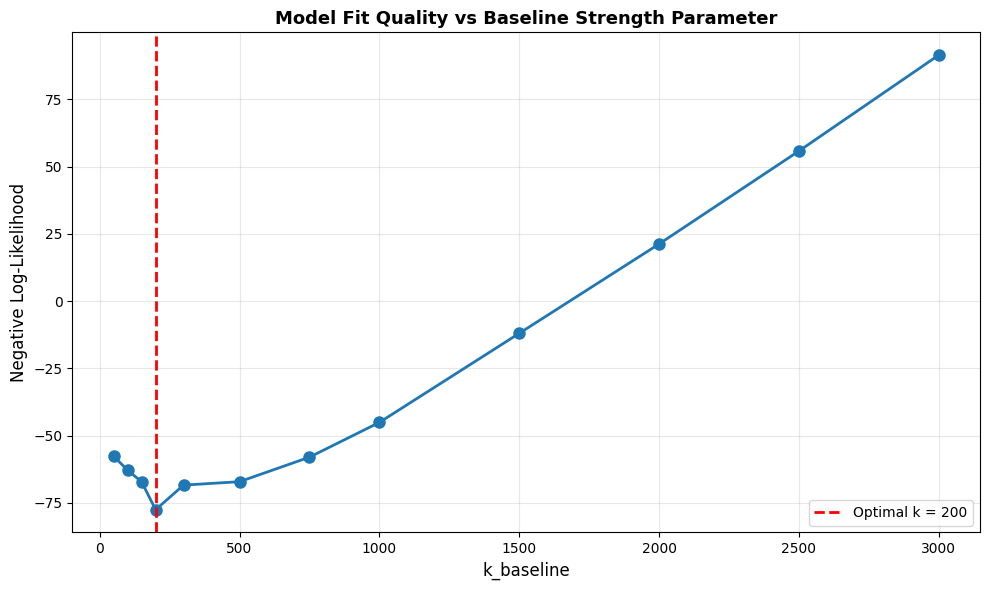

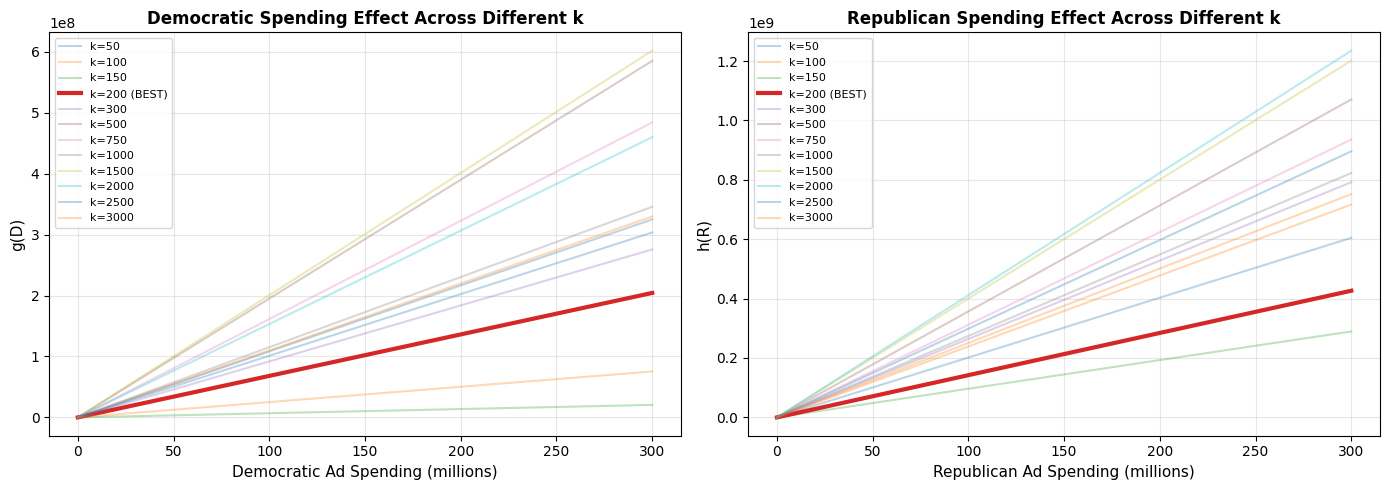


FINAL FIT WITH OPTIMAL k

Democratic spending effect g(D):
  g1   = 680978.2762174995

Republican spending effect h(R):
  h1   = 1421714.3172780694

Optimal k_baseline = 200
Final neg log-likelihood: -77.5037

Model fit:
  Mean absolute error: 0.0290
  RMSE: 0.0329

PLOTTING OPTIMAL SPENDING EFFECT FUNCTIONS


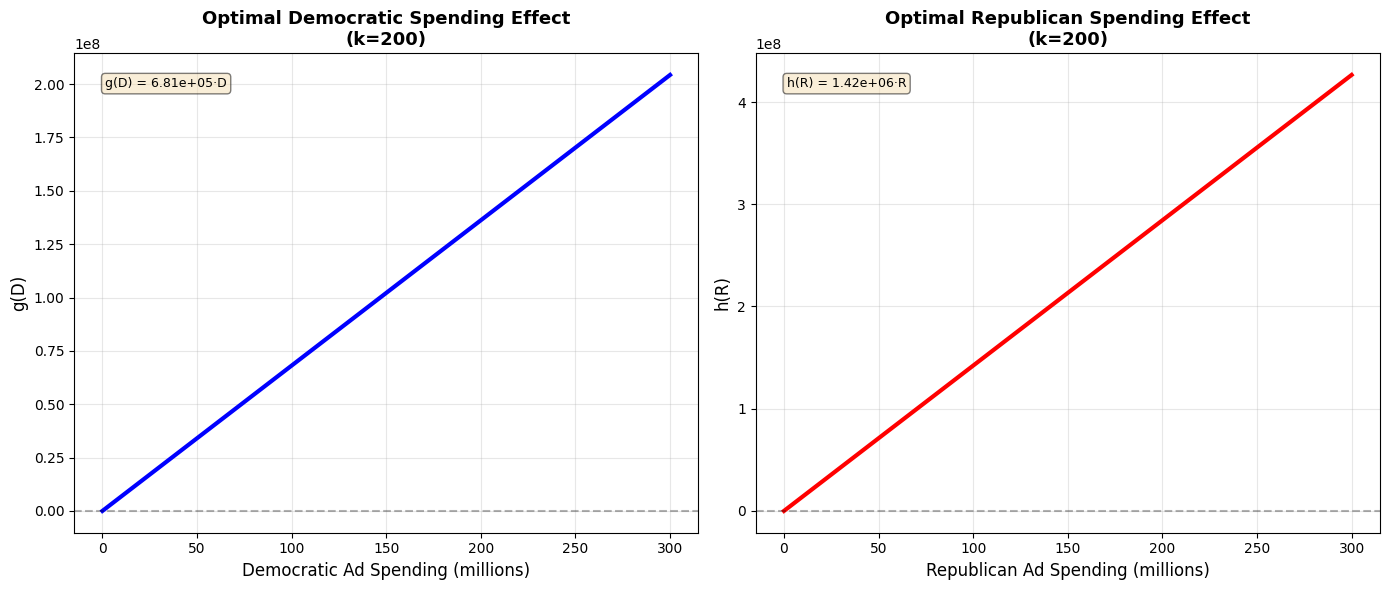


GENERATING STATE-BY-STATE BETA DISTRIBUTIONS


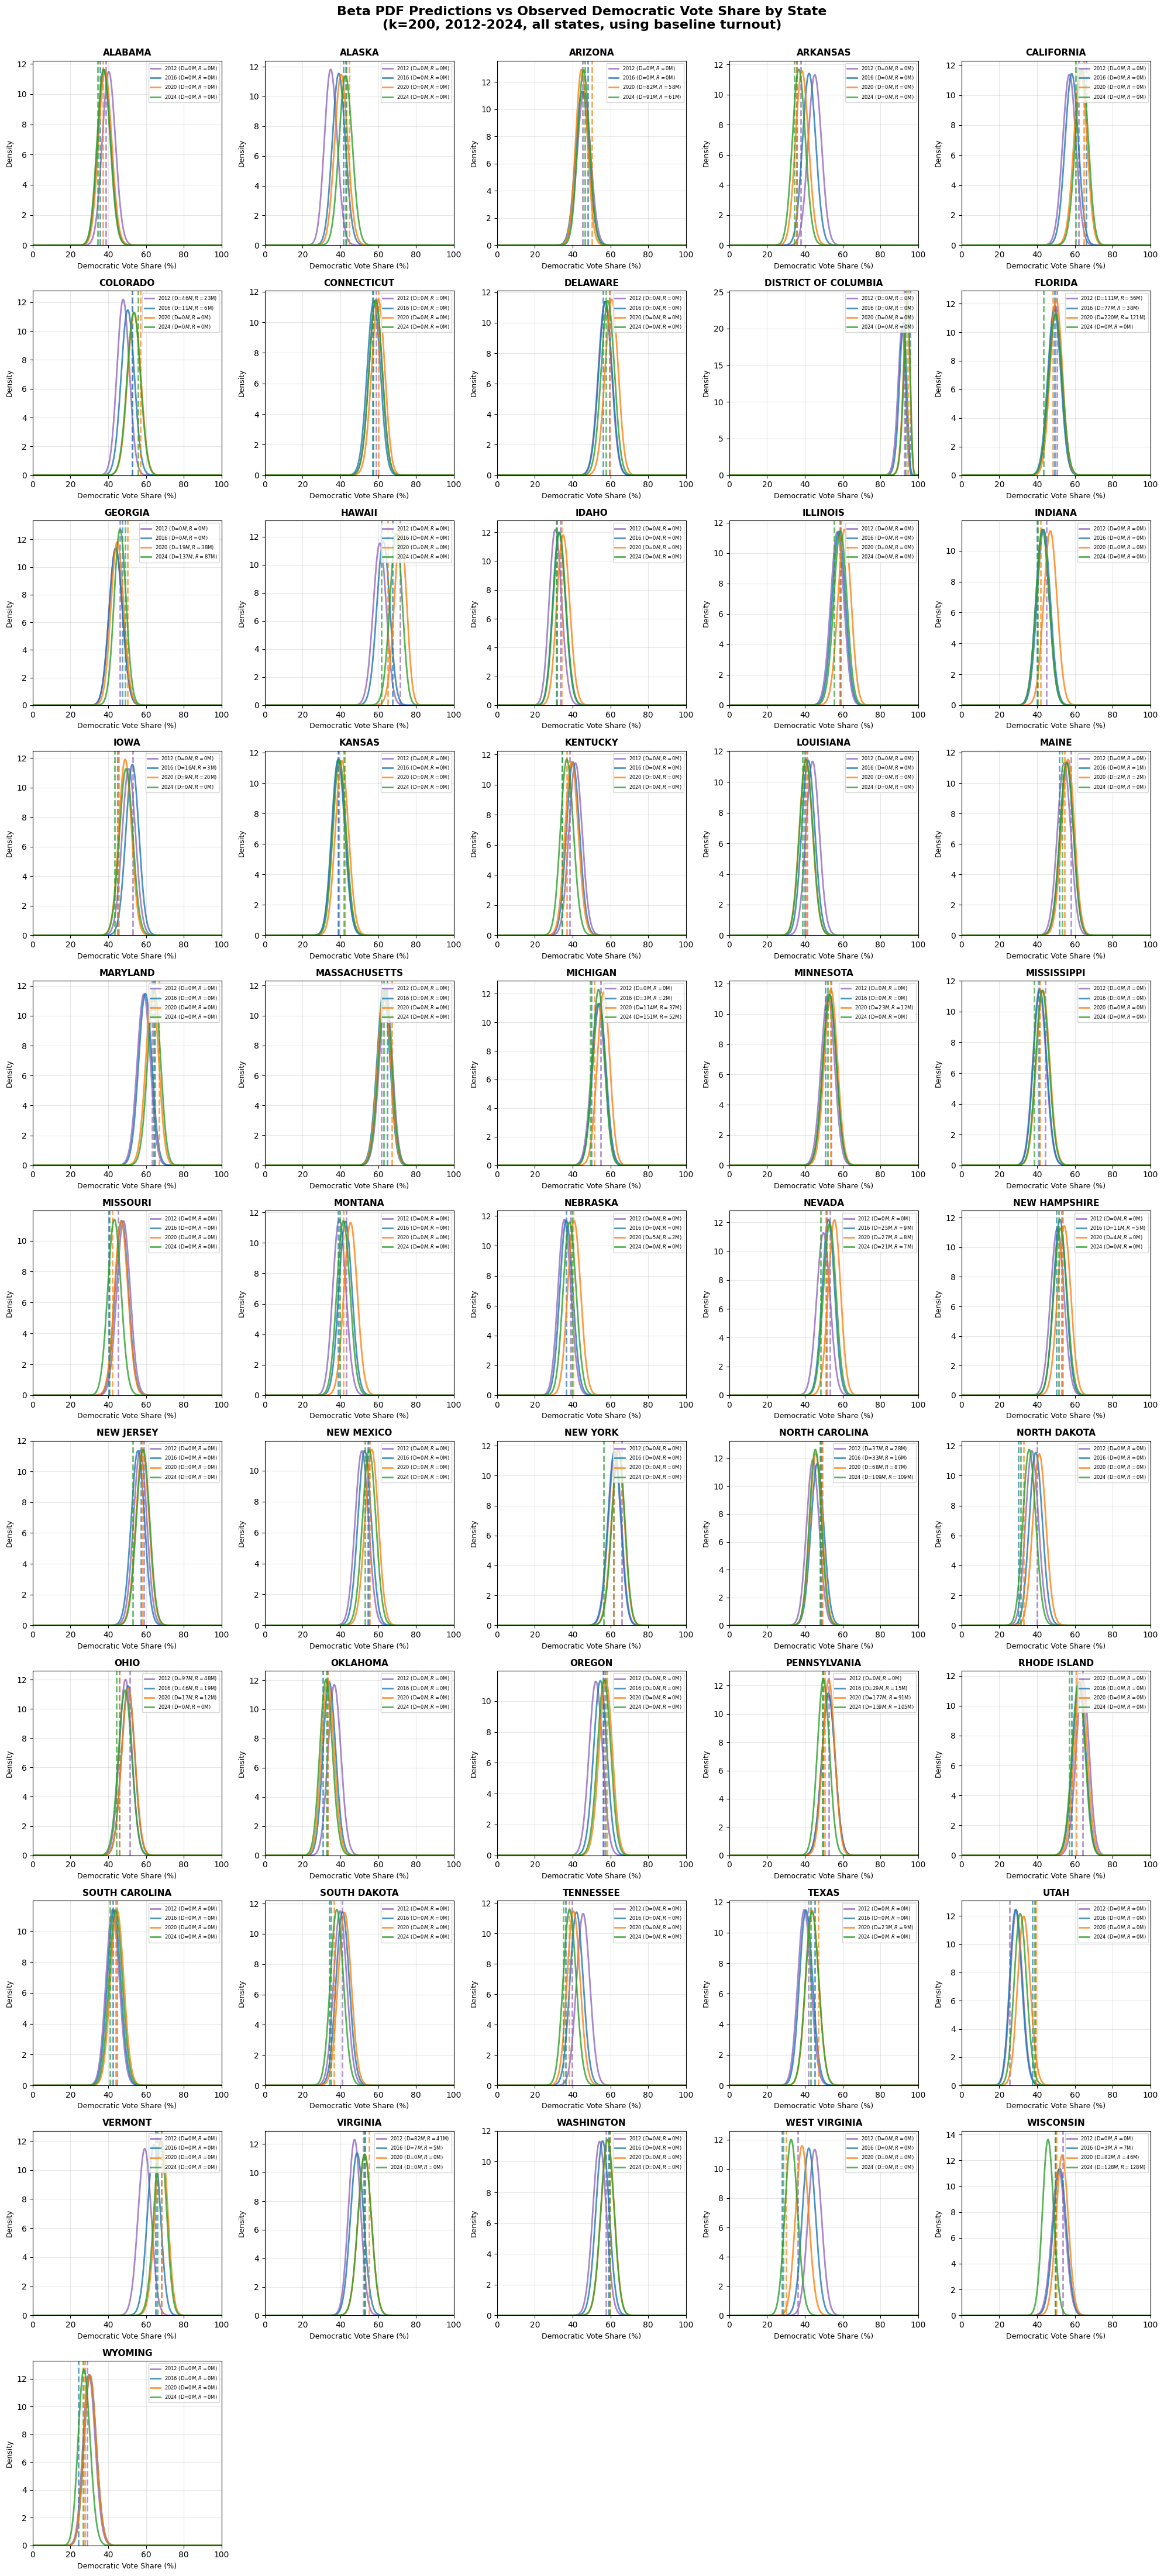


SENSITIVITY ANALYSIS: WYOMING, TEXAS, OHIO 2016

WYOMING: Baseline Pop=241,309, Baseline=0.306, Actual=0.243


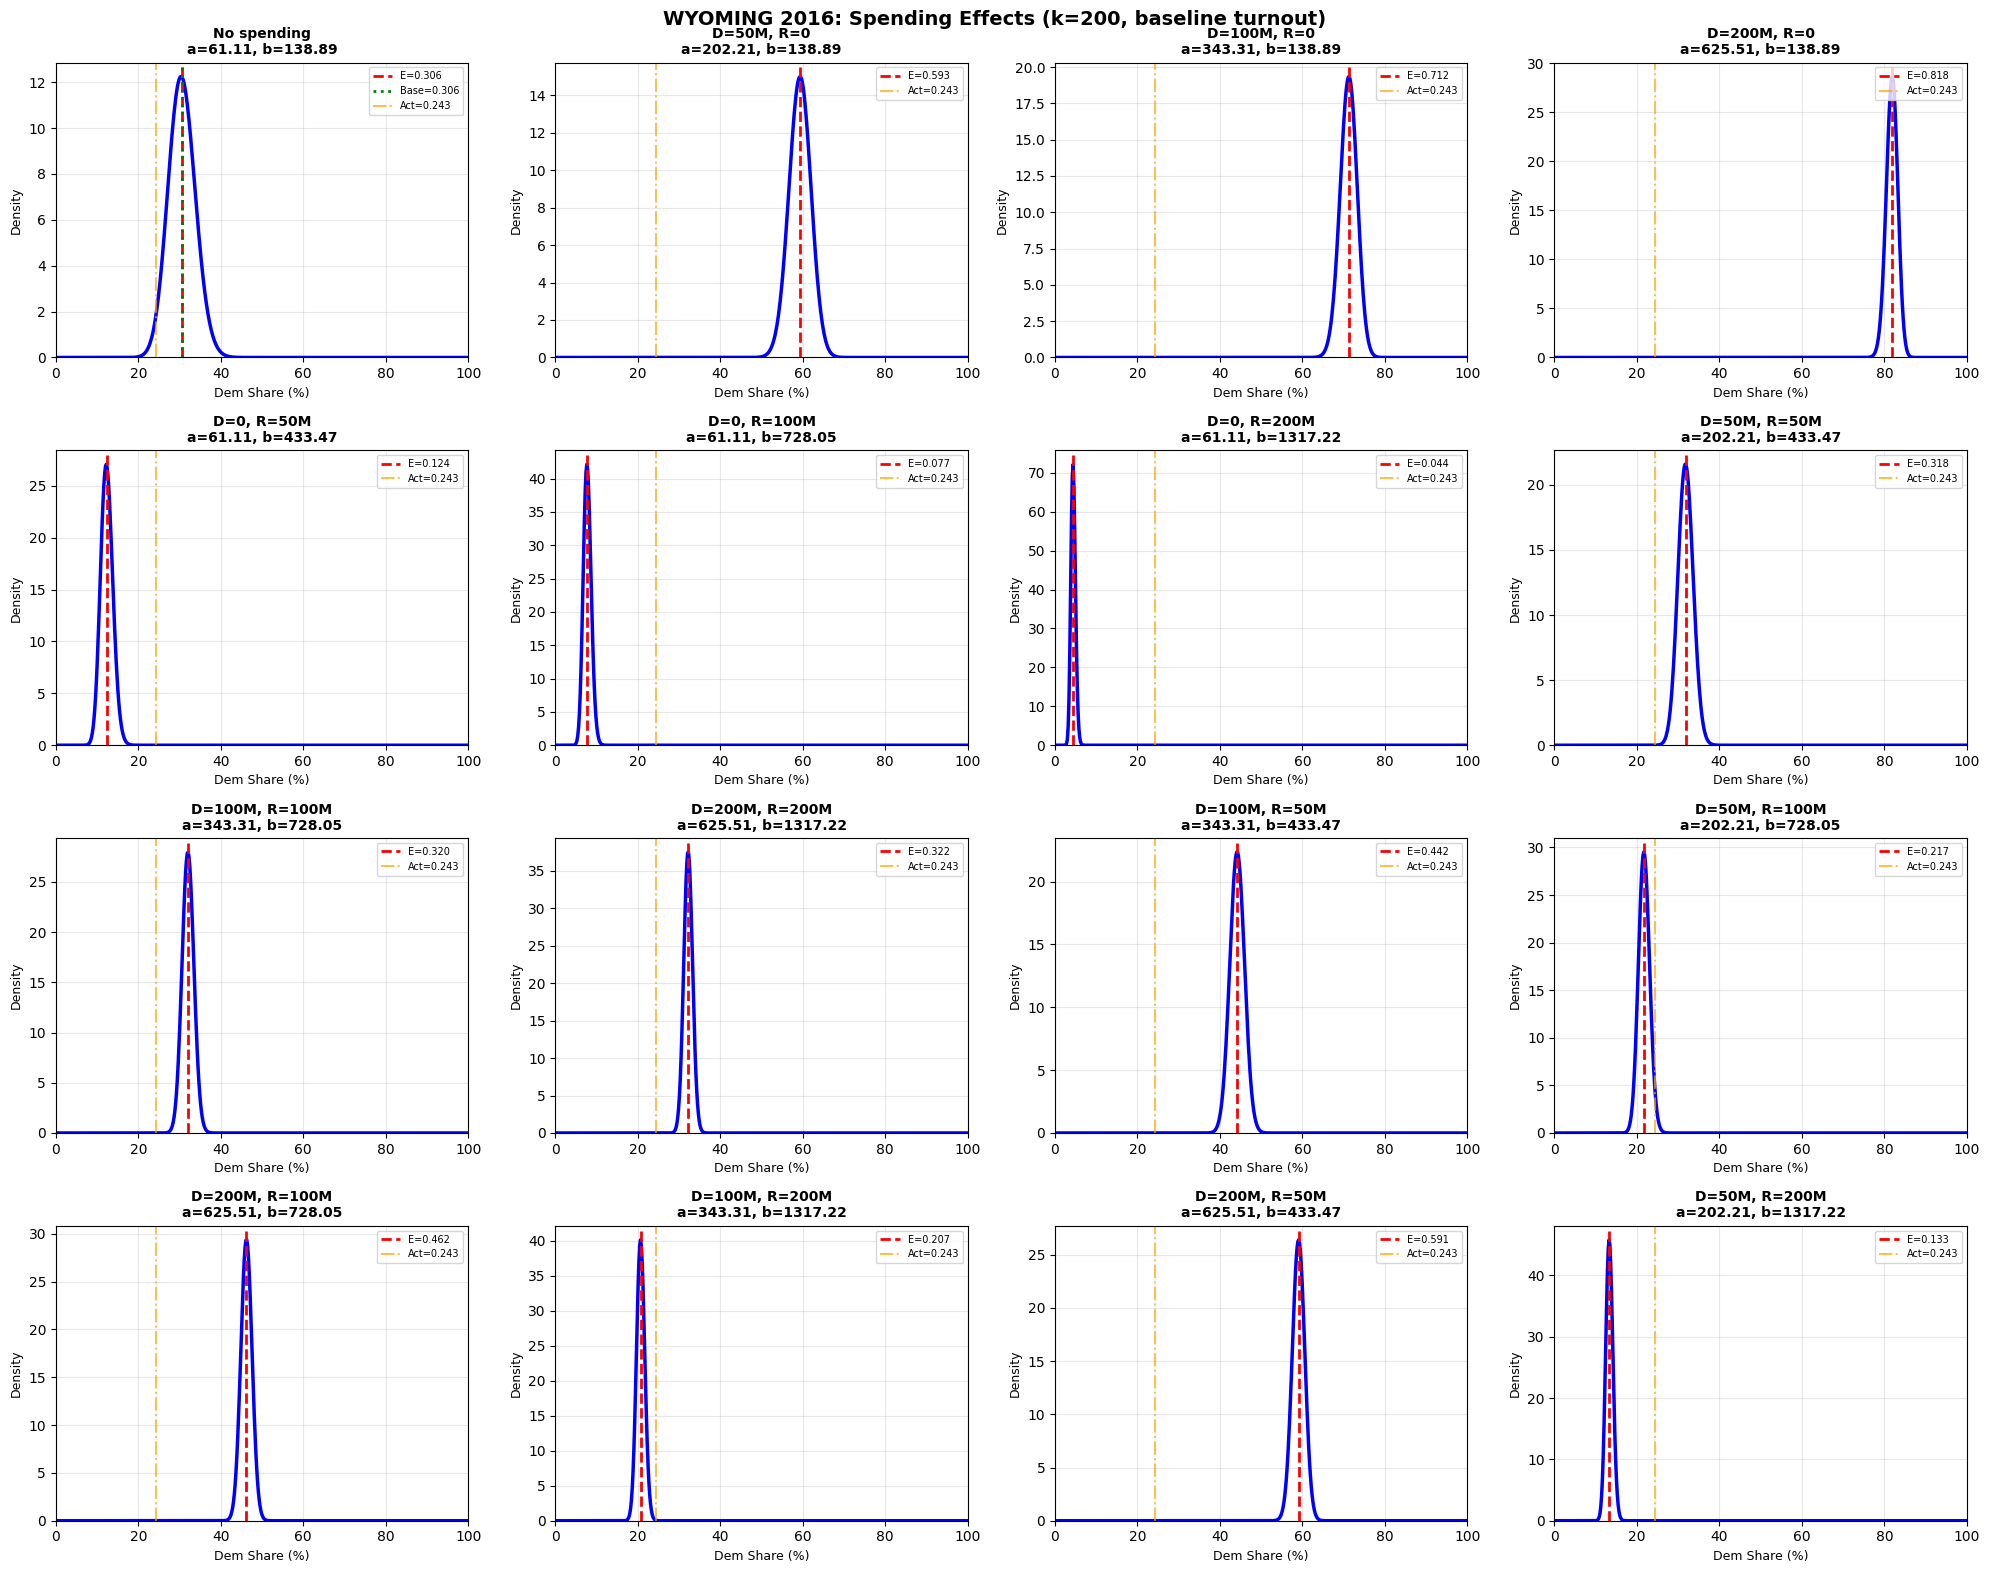


TEXAS: Baseline Pop=7,630,686, Baseline=0.406, Actual=0.453


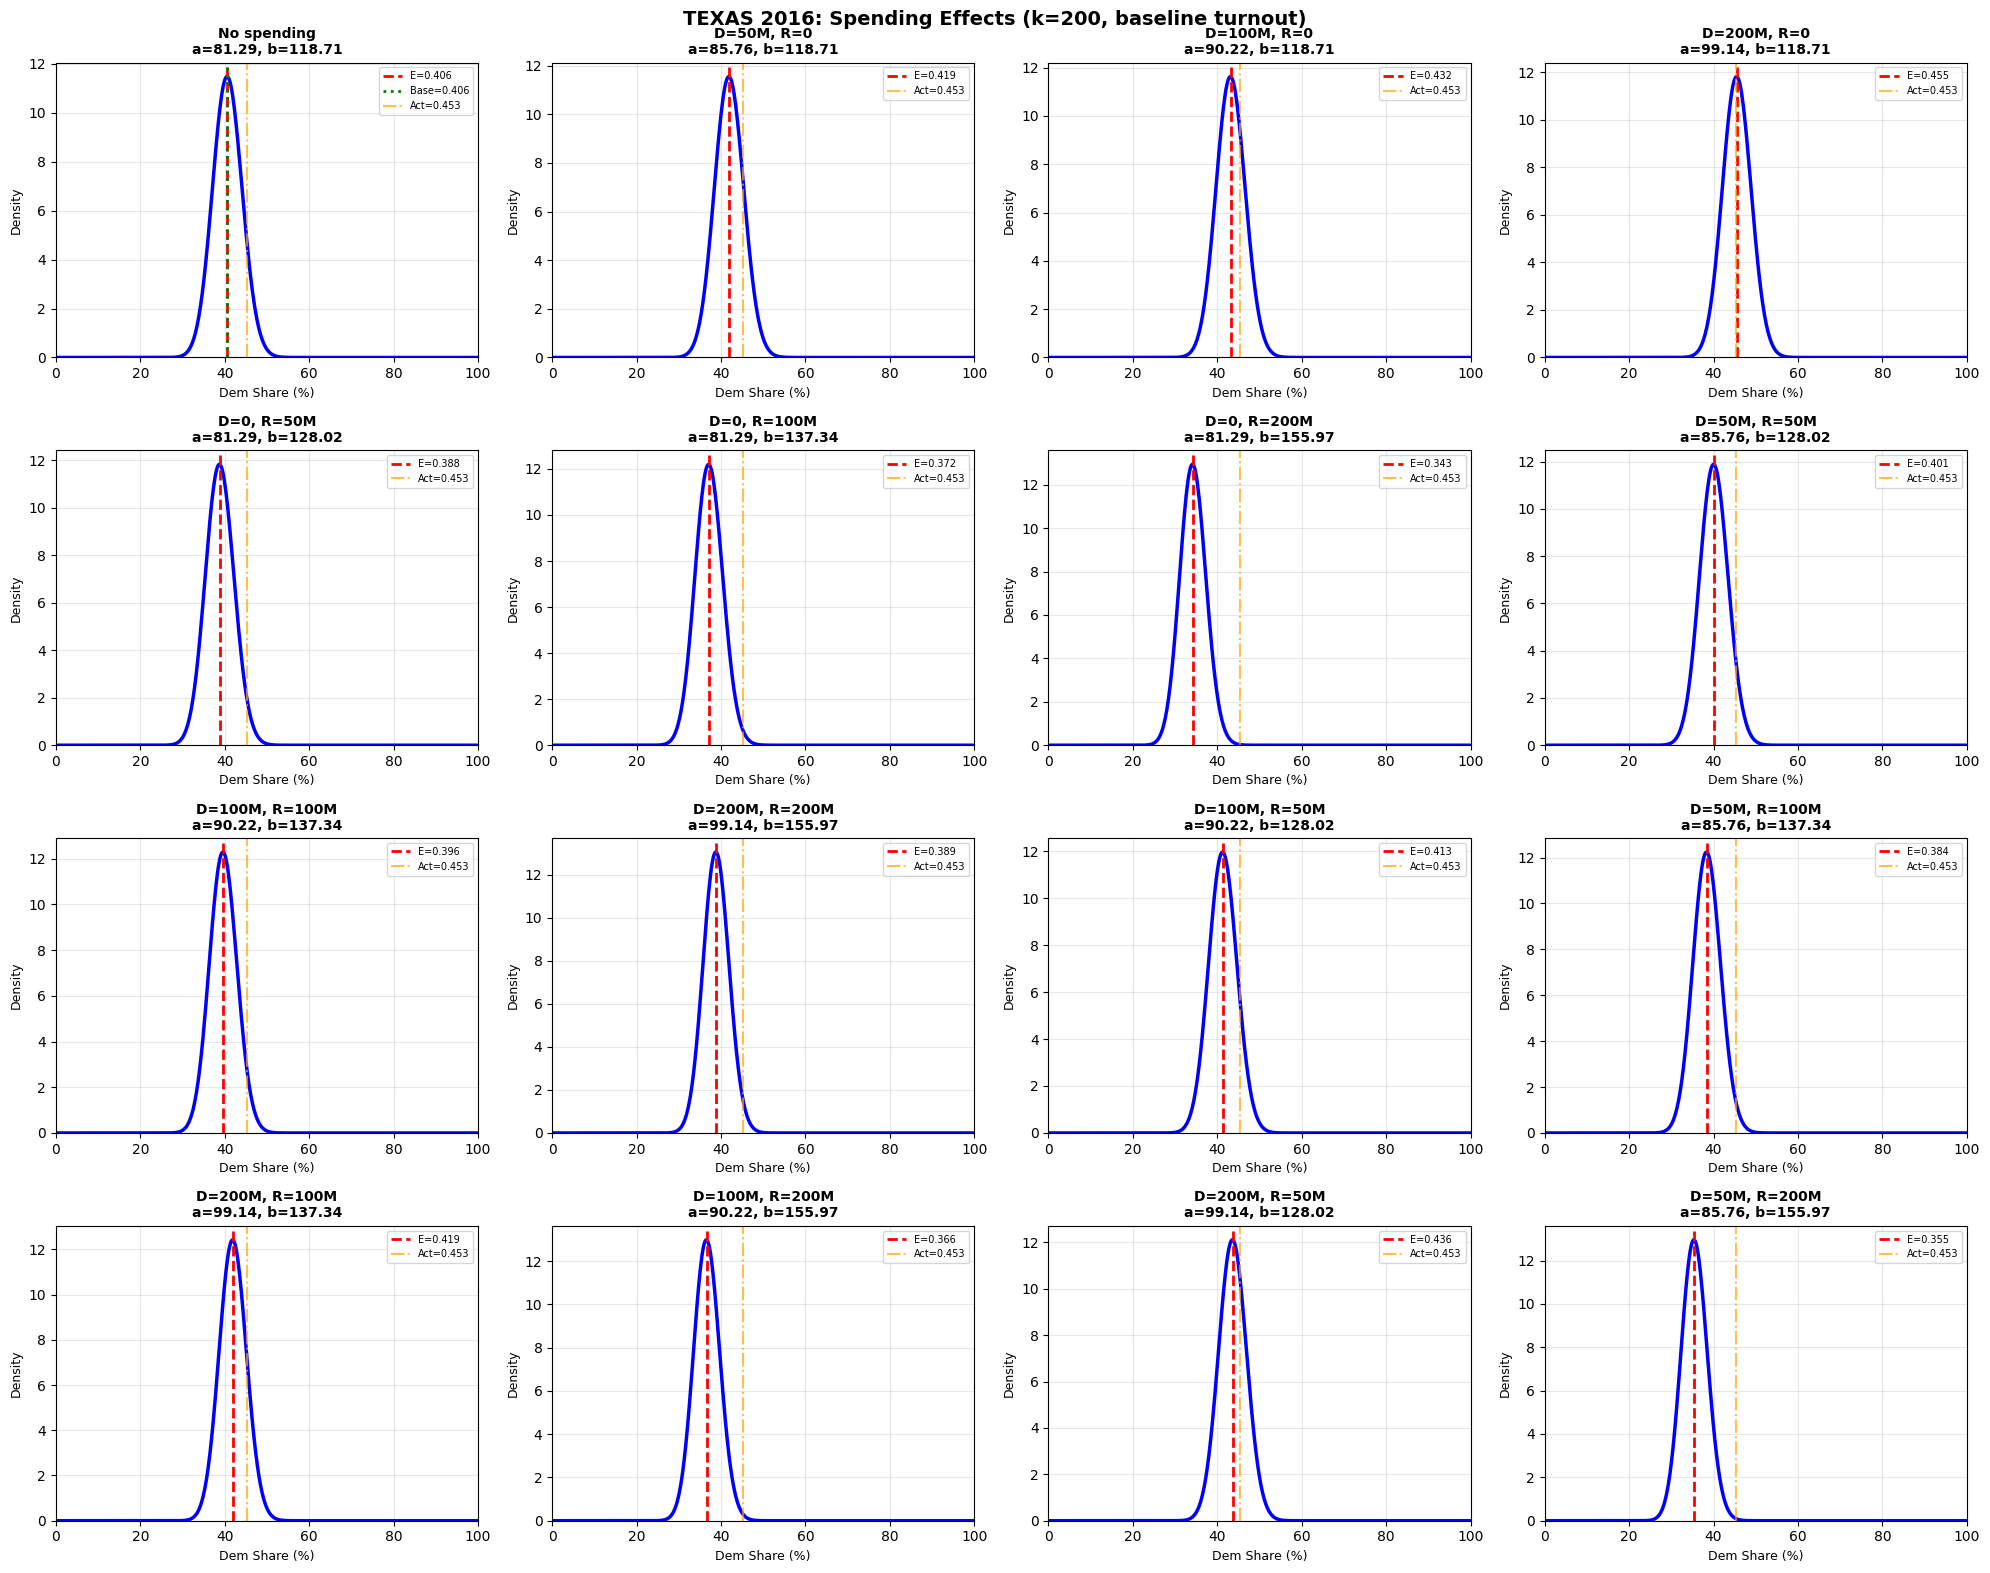


OHIO: Baseline Pop=5,581,252, Baseline=0.503, Actual=0.457


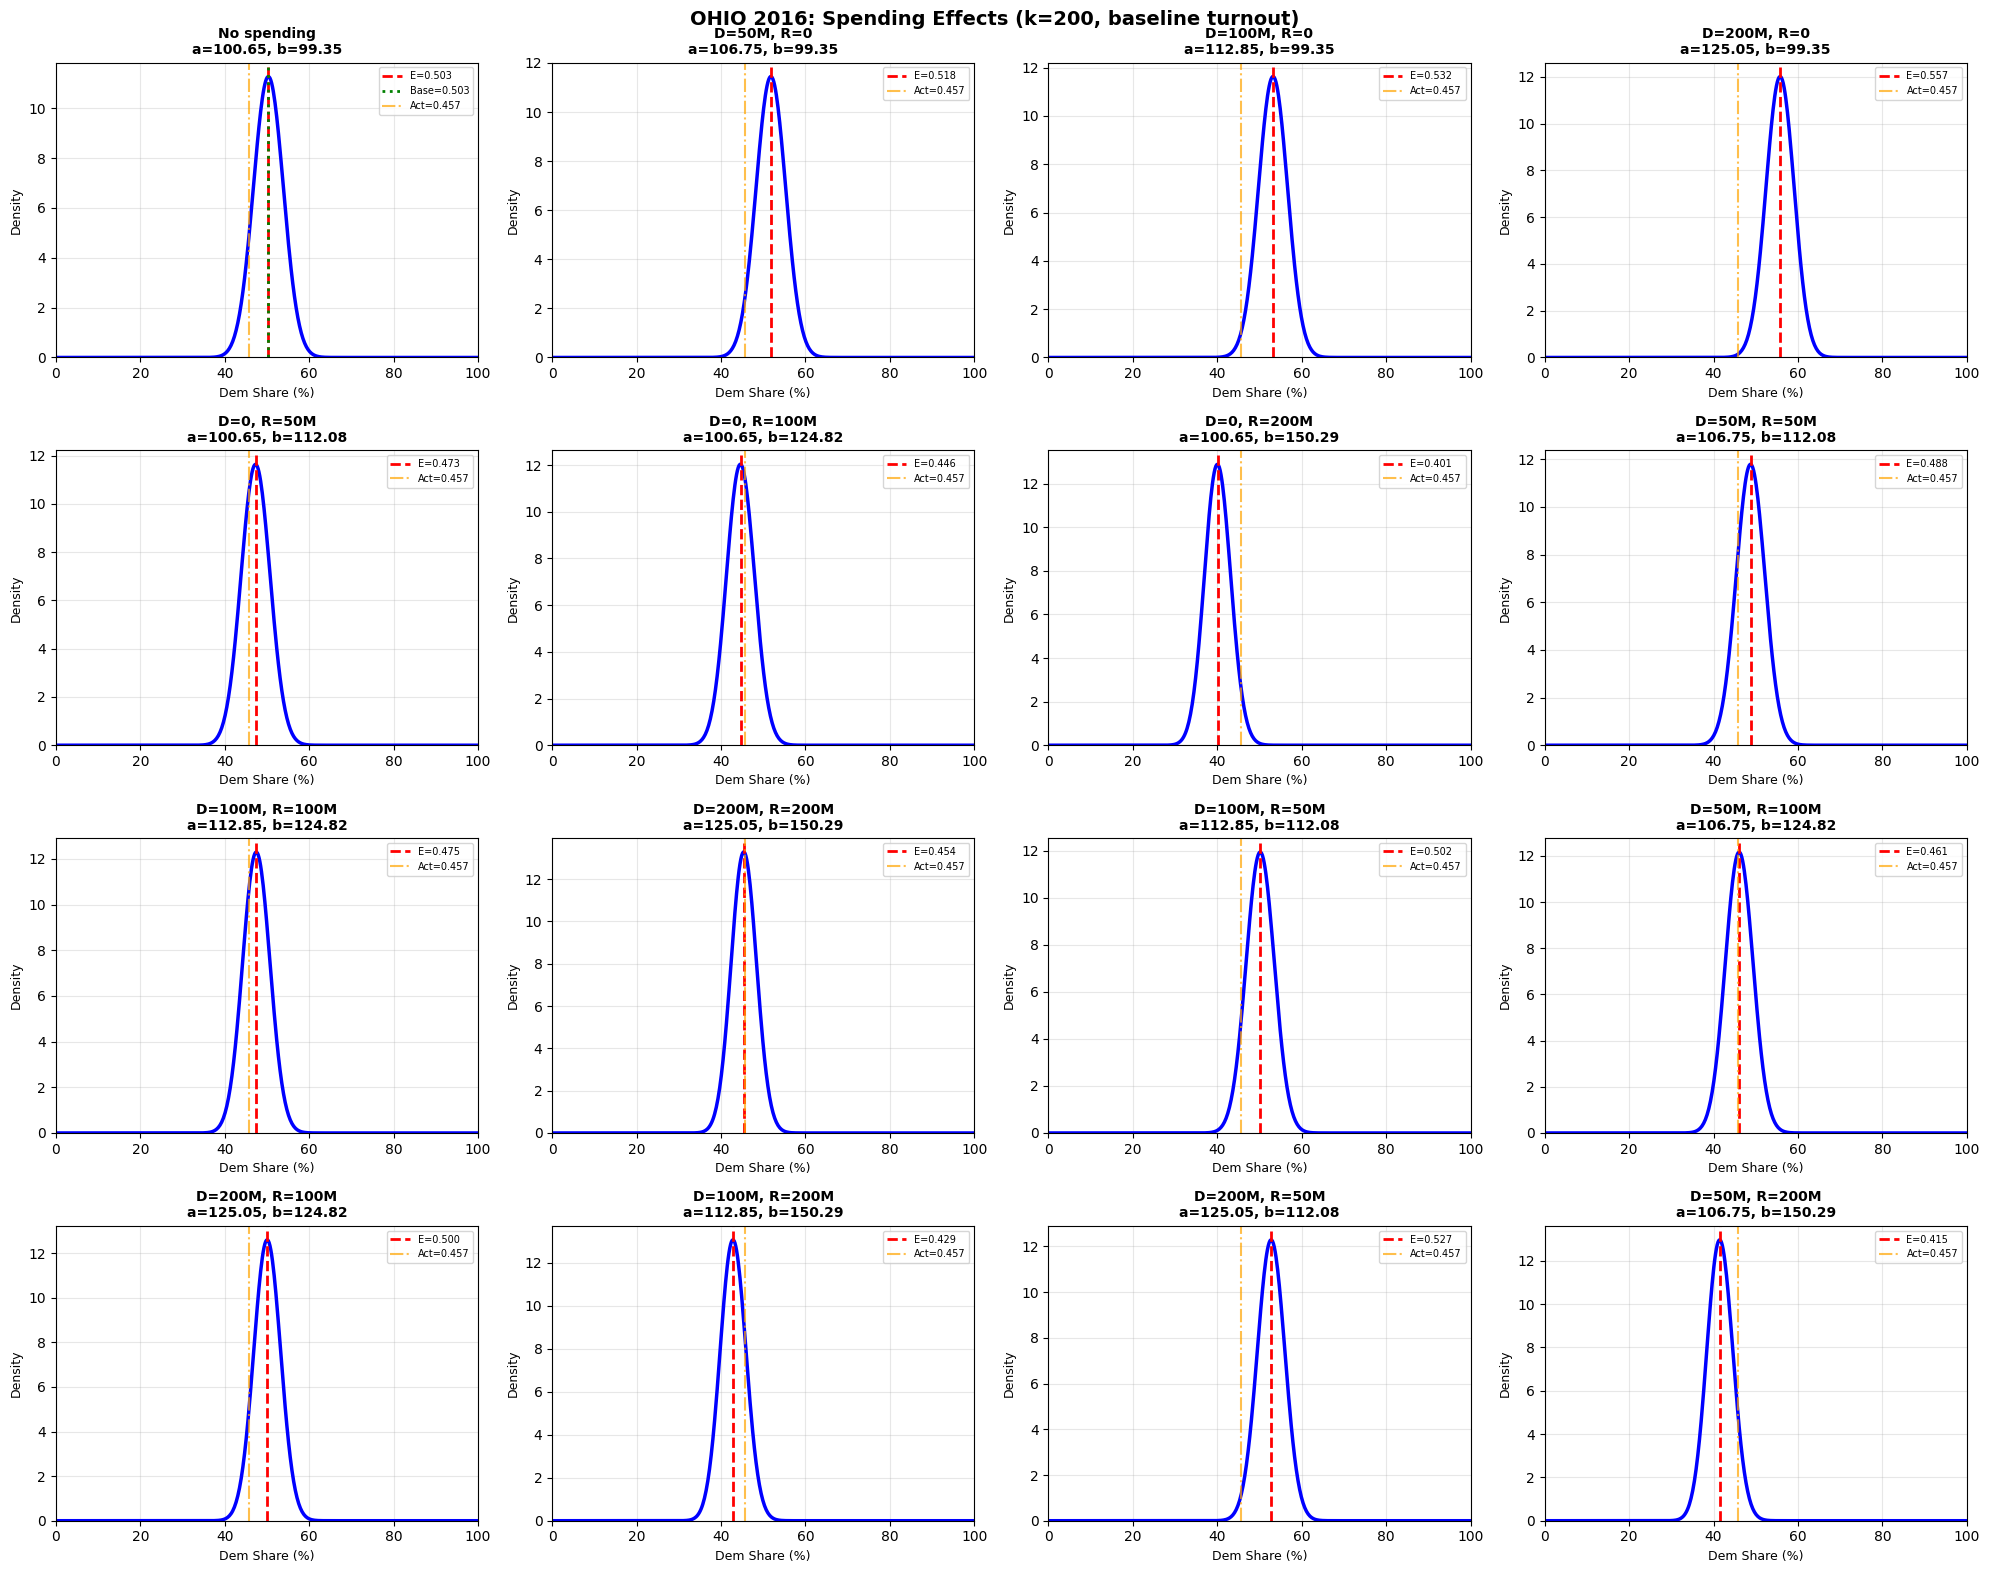


MODEL SUMMARY
Optimal k = 200
Use these fitted parameters for simulation:
  g(D) and h(R) functions with coefficients above
  N = Baseline_total_partisan (weighted avg of past 3 elections)


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from scipy.optimize import minimize

# Load data
county_df = pd.read_csv('countypres_2000-2024.csv')
ad_df = pd.read_csv('ad_data.csv')

# --- Calculate Democratic Vote Share by State and Year ---
state_partisan_votes = county_df[county_df['party'].isin(['DEMOCRAT', 'REPUBLICAN'])].groupby(
    ['year', 'state', 'party']
)['candidatevotes'].sum().unstack(fill_value=0).reset_index()

state_partisan_votes['DEM_SHARE'] = state_partisan_votes['DEMOCRAT'] / (
    state_partisan_votes['DEMOCRAT'] + state_partisan_votes['REPUBLICAN'])
state_partisan_votes['total_partisan'] = state_partisan_votes['DEMOCRAT'] + state_partisan_votes['REPUBLICAN']
state_partisan_votes = state_partisan_votes.sort_values(['state', 'year']).reset_index(drop=True)

# Calculate weighted 3-year prior Democratic share (baseline partisan lean)
def past_3_inverse_weights(series):
    s = series.shift(1)
    values = np.full(series.shape[0], np.nan)
    weights = np.array([1, 1/2, 1/3])
    for i in range(3, len(s)+1):
        window = s.iloc[i-3:i].values
        if np.isnan(window).any():
            continue
        weighted_avg = np.dot(window, weights) / np.sum(weights)
        values[i-1] = weighted_avg
    return pd.Series(values, index=series.index)

state_partisan_votes['Baseline_DEM_SHARE'] = (
    state_partisan_votes.groupby('state')['DEM_SHARE'].transform(past_3_inverse_weights)
)

# Calculate weighted 3-year prior total partisan votes (baseline turnout)
state_partisan_votes['Baseline_total_partisan'] = (
    state_partisan_votes.groupby('state')['total_partisan'].transform(past_3_inverse_weights)
)

# Standardize state names
state_partisan_votes['state'] = state_partisan_votes['state'].str.upper()
ad_df['State'] = ad_df['State'].str.upper()

# Merge with ad spending
combined_data = ad_df.merge(
    state_partisan_votes[['year', 'state', 'total_partisan', 'DEM_SHARE', 'Baseline_DEM_SHARE', 'Baseline_total_partisan']],
    left_on=['year', 'State'],
    right_on=['year', 'state'],
    how='inner'
)

# Filter out Iowa 2016
combined_data = combined_data[~((combined_data['State'] == 'IOWA') & (combined_data['year'] == 2016))]
combined_data = combined_data.dropna(subset=['D-ad-spending', 'R-ad-spending', 'DEM_SHARE', 'total_partisan', 'Baseline_DEM_SHARE', 'Baseline_total_partisan'])

eps = 1e-7

# === Define model functions ===
def g(D, g1):
    """Democratic spending effect - linear only"""
    return g1 * D

def h(R, h1):
    """Republican spending effect - linear only"""
    return h1 * R

def neg_log_likelihood(params, D_spending, R_spending, dem_share_clipped, baseline_total_partisan, p_D_fixed, p_R_fixed):
    """Negative log-likelihood for optimization - now only linear basis functions"""
    g1, h1 = params

    if np.any(np.array([g1, h1]) < 0):
        return 1e12

    g_vals = g(D_spending, g1)
    h_vals = h(R_spending, h1)

    a_vals = (1.0 / baseline_total_partisan) * g_vals + p_D_fixed
    b_vals = (1.0 / baseline_total_partisan) * h_vals + p_R_fixed

    if np.any(a_vals <= 0) or np.any(b_vals <= 0):
        return 1e12

    ll = np.sum(beta.logpdf(dem_share_clipped, a_vals, b_vals))
    return -ll

# Initial parameters and bounds (linear only!)
initial_params = np.array([5e5, 5e5])
bounds = [
    (0, None),  # g1
    (0, None),  # h1
]

# === PARAMETER SEARCH FOR OPTIMAL k_baseline ===
print("\n" + "="*80)
print("SEARCHING FOR OPTIMAL k_baseline WITH MULTIPLE INITIALIZATIONS")
print("="*80)

k_values = [50, 100, 150, 200, 300, 500, 750, 1000, 1500, 2000, 2500, 3000]
results_by_k = []

n_random_starts = 50  # Try 50 different random initializations per k

for k_baseline in k_values:
    print(f"\nTrying k_baseline = {k_baseline}...")

    combined_data['p_D'] = k_baseline * combined_data['Baseline_DEM_SHARE']
    combined_data['p_R'] = k_baseline * (1 - combined_data['Baseline_DEM_SHARE'])

    D_spending = combined_data['D-ad-spending'].values
    R_spending = combined_data['R-ad-spending'].values
    dem_share = combined_data['DEM_SHARE'].values
    baseline_total_partisan = combined_data['Baseline_total_partisan'].values
    p_D_fixed = combined_data['p_D'].values
    p_R_fixed = combined_data['p_R'].values
    dem_share_clipped = np.clip(dem_share, eps, 1 - eps)

    best_nll = np.inf
    best_params_for_k = None
    best_success = False

    # Try multiple random initializations
    for i in range(n_random_starts):
        random_init = np.array([
            np.random.uniform(1e4, 1e7),  # g1
            np.random.uniform(1e4, 1e7),  # h1
        ])

        result_k = minimize(
            lambda p: neg_log_likelihood(p, D_spending, R_spending, dem_share_clipped, baseline_total_partisan, p_D_fixed, p_R_fixed),
            random_init, bounds=bounds, method='L-BFGS-B', options={'maxiter': 1000, 'ftol': 1e-8}
        )

        if result_k.success and result_k.fun < best_nll:
            best_nll = result_k.fun
            best_params_for_k = result_k.x.copy()
            best_success = True

    results_by_k.append({
        'k_baseline': k_baseline,
        'neg_log_likelihood': best_nll,
        'success': best_success,
        'params': best_params_for_k
    })

    print(f"  Best Neg Log-Likelihood: {best_nll:.4f} (from {n_random_starts} random starts)")

# Find best k
results_df = pd.DataFrame(results_by_k)
best_idx = results_df['neg_log_likelihood'].idxmin()
best_k = results_df.loc[best_idx, 'k_baseline']
best_params = results_df.loc[best_idx, 'params']

print("\n" + "="*80)
print("k_baseline SEARCH RESULTS")
print("="*80)
print(results_df[['k_baseline', 'neg_log_likelihood', 'success']].to_string(index=False))
print(f"\nOPTIMAL k_baseline = {best_k}")

# Plot likelihood vs k
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(results_df['k_baseline'], results_df['neg_log_likelihood'], 'o-', lw=2, markersize=8)
ax.axvline(best_k, color='r', linestyle='--', lw=2, label=f'Optimal k = {best_k}')
ax.set_xlabel('k_baseline', fontsize=12)
ax.set_ylabel('Negative Log-Likelihood', fontsize=12)
ax.set_title('Model Fit Quality vs Baseline Strength Parameter', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot spending effect curves for different k values
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

D_range_viz = np.linspace(0, 300, 200)
R_range_viz = np.linspace(0, 300, 200)

for i, row in results_df.iterrows():
    if row['success'] and row['params'] is not None:
        k_val = row['k_baseline']
        params = row['params']
        g1 = params[0]
        h1 = params[1]

        g_curve = g(D_range_viz, g1)
        h_curve = h(R_range_viz, h1)

        alpha = 0.3 if k_val != best_k else 1.0
        lw = 1.5 if k_val != best_k else 3.0
        label = f'k={k_val}' + (' (BEST)' if k_val == best_k else '')

        axes[0].plot(D_range_viz, g_curve, alpha=alpha, lw=lw, label=label)
        axes[1].plot(R_range_viz, h_curve, alpha=alpha, lw=lw, label=label, color=f'C{i}')

axes[0].set_xlabel('Democratic Ad Spending (millions)', fontsize=11)
axes[0].set_ylabel('g(D)', fontsize=11)
axes[0].set_title('Democratic Spending Effect Across Different k', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=8)
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Republican Ad Spending (millions)', fontsize=11)
axes[1].set_ylabel('h(R)', fontsize=11)
axes[1].set_title('Republican Spending Effect Across Different k', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=8)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# === FIT FINAL MODEL WITH OPTIMAL k ===
k_baseline = best_k
combined_data['p_D'] = k_baseline * combined_data['Baseline_DEM_SHARE']
combined_data['p_R'] = k_baseline * (1 - combined_data['Baseline_DEM_SHARE'])

D_spending = combined_data['D-ad-spending'].values
R_spending = combined_data['R-ad-spending'].values
dem_share = combined_data['DEM_SHARE'].values
baseline_total_partisan = combined_data['Baseline_total_partisan'].values
p_D_fixed = combined_data['p_D'].values
p_R_fixed = combined_data['p_R'].values
dem_share_clipped = np.clip(dem_share, eps, 1 - eps)

print("\n" + "="*80)
print("FINAL FIT WITH OPTIMAL k")
print("="*80)

result = minimize(
    lambda p: neg_log_likelihood(p, D_spending, R_spending, dem_share_clipped, baseline_total_partisan, p_D_fixed, p_R_fixed),
    best_params, bounds=bounds, method='L-BFGS-B', options={'maxiter': 2000, 'ftol': 1e-9}
)

g1_opt = result.x[0]
h1_opt = result.x[1]

print(f"\nDemocratic spending effect g(D):")
print(f"  g1   = {g1_opt}")

print(f"\nRepublican spending effect h(R):")
print(f"  h1   = {h1_opt}")

print(f"\nOptimal k_baseline = {k_baseline}")
print(f"Final neg log-likelihood: {result.fun:.4f}")

# Calculate fitted values for diagnostics
g_vals_fitted = g(D_spending, g1_opt)
h_vals_fitted = h(R_spending, h1_opt)
a_fitted = (1.0 / baseline_total_partisan) * g_vals_fitted + p_D_fixed
b_fitted = (1.0 / baseline_total_partisan) * h_vals_fitted + p_R_fixed
predicted_share = a_fitted / (a_fitted + b_fitted)

residuals = dem_share - predicted_share
print(f"\nModel fit:")
print(f"  Mean absolute error: {np.mean(np.abs(residuals)):.4f}")
print(f"  RMSE: {np.sqrt(np.mean(residuals**2)):.4f}")

# === PLOT FINAL OPTIMAL g(D) AND h(R) FUNCTIONS ===
print("\n" + "="*80)
print("PLOTTING OPTIMAL SPENDING EFFECT FUNCTIONS")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

D_range_final = np.linspace(0, 300, 500)
R_range_final = np.linspace(0, 300, 500)

g_final = g(D_range_final, g1_opt)
h_final = h(R_range_final, h1_opt)

axes[0].plot(D_range_final, g_final, 'b-', lw=3)
axes[0].set_xlabel('Democratic Ad Spending (millions)', fontsize=12)
axes[0].set_ylabel('g(D)', fontsize=12)
axes[0].set_title(f'Optimal Democratic Spending Effect\n(k={k_baseline})', 
                  fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(0, color='k', linestyle='--', alpha=0.3)

g_text = (f"g(D) = {g1_opt:.2e}·D")
axes[0].text(0.05, 0.95, g_text, transform=axes[0].transAxes,
            fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

axes[1].plot(R_range_final, h_final, 'r-', lw=3)
axes[1].set_xlabel('Republican Ad Spending (millions)', fontsize=12)
axes[1].set_ylabel('h(R)', fontsize=12)
axes[1].set_title(f'Optimal Republican Spending Effect\n(k={k_baseline})', 
                  fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(0, color='k', linestyle='--', alpha=0.3)

h_text = (f"h(R) = {h1_opt:.2e}·R")
axes[1].text(0.05, 0.95, h_text, transform=axes[1].transAxes,
            fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# === PLOT ALL 51 STATE DISTRIBUTIONS FOR 2012-2024 ===
print("\n" + "="*80)
print("GENERATING STATE-BY-STATE BETA DISTRIBUTIONS")
print("="*80)

# Prepare all states data
all_state_votes = state_partisan_votes.copy()
all_state_votes['p_D'] = k_baseline * all_state_votes['Baseline_DEM_SHARE']
all_state_votes['p_R'] = k_baseline * (1 - all_state_votes['Baseline_DEM_SHARE'])

all_states_data = all_state_votes.merge(
    ad_df[['year', 'State', 'D-ad-spending', 'R-ad-spending']],
    left_on=['year', 'state'], right_on=['year', 'State'], how='left'
)
all_states_data['D-ad-spending'] = all_states_data['D-ad-spending'].fillna(0)
all_states_data['R-ad-spending'] = all_states_data['R-ad-spending'].fillna(0)

years_to_plot = [2012, 2016, 2020, 2024]
plot_data = all_states_data[all_states_data['year'].isin(years_to_plot)].copy()
plot_data = plot_data.dropna(subset=['p_D', 'p_R', 'Baseline_total_partisan'])

# Calculate a and b for each state-year using BASELINE turnout
D_plot = plot_data['D-ad-spending'].values
R_plot = plot_data['R-ad-spending'].values
N_plot = plot_data['Baseline_total_partisan'].values
p_D_plot = plot_data['p_D'].values
p_R_plot = plot_data['p_R'].values

g_plot = g(D_plot, g1_opt)
h_plot = h(R_plot, h1_opt)

plot_data['a'] = (1.0 / N_plot) * g_plot + p_D_plot
plot_data['b'] = (1.0 / N_plot) * h_plot + p_R_plot

# Create state plots
unique_plot_states = sorted(plot_data['state'].unique())
n_plot_states = len(unique_plot_states)
n_cols = 5
n_rows = (n_plot_states + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

x_range = np.linspace(0, 1, 500)
year_colors = {2012: '#9467bd', 2016: '#1f77b4', 2020: '#ff7f0e', 2024: '#2ca02c'}

for idx, state in enumerate(unique_plot_states):
    ax = axes[idx]
    state_entries = plot_data[plot_data['state'] == state]

    for _, row in state_entries.iterrows():
        a_val = row['a']
        b_val = row['b']
        dem_share_actual = row['DEM_SHARE']
        year = int(row['year'])
        d_spend = row['D-ad-spending']
        r_spend = row['R-ad-spending']
        color = year_colors.get(year, 'gray')

        pdf_vals = beta.pdf(x_range, a_val, b_val)

        ax.plot(x_range * 100, pdf_vals, linewidth=2, color=color,
                label=f'{year} (D=${d_spend:.0f}M, R=${r_spend:.0f}M)', alpha=0.8)

        ax.axvline(x=dem_share_actual * 100, linestyle='--', linewidth=2,
                   alpha=0.7, color=color)

    ax.set_xlim(0, 100)
    ax.set_ylim(bottom=0)
    ax.set_xlabel('Democratic Vote Share (%)', fontsize=9)
    ax.set_ylabel('Density', fontsize=9)
    ax.set_title(f'{state}', fontsize=11, fontweight='bold')
    ax.legend(fontsize=6, loc='upper right')
    ax.grid(True, alpha=0.3)

for idx in range(n_plot_states, len(axes)):
    axes[idx].axis('off')

plt.suptitle(
    f'Beta PDF Predictions vs Observed Democratic Vote Share by State\n'
    f'(k={k_baseline}, 2012-2024, all states, using baseline turnout)',
    fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# === SENSITIVITY ANALYSIS FOR WYOMING, TEXAS, OHIO 2016 ===
print("\n" + "="*80)
print("SENSITIVITY ANALYSIS: WYOMING, TEXAS, OHIO 2016")
print("="*80)

test_scenarios = [
    (0, 0, "No spending"), (50, 0, "D=50M, R=0"), (100, 0, "D=100M, R=0"), (200, 0, "D=200M, R=0"),
    (0, 50, "D=0, R=50M"), (0, 100, "D=0, R=100M"), (0, 200, "D=0, R=200M"),
    (50, 50, "D=50M, R=50M"), (100, 100, "D=100M, R=100M"), (200, 200, "D=200M, R=200M"),
    (100, 50, "D=100M, R=50M"), (50, 100, "D=50M, R=100M"), (200, 100, "D=200M, R=100M"),
    (100, 200, "D=100M, R=200M"), (200, 50, "D=200M, R=50M"), (50, 200, "D=50M, R=200M"),
]

for state_name in ['WYOMING', 'TEXAS', 'OHIO']:
    state_data = all_states_data[(all_states_data['state'] == state_name) & (all_states_data['year'] == 2016)]

    if len(state_data) == 0:
        print(f"\n{state_name} 2016 data not found, skipping...")
        continue

    state_row = state_data.iloc[0]
    N_state = state_row['Baseline_total_partisan']
    p_D_state = state_row['p_D']
    p_R_state = state_row['p_R']
    actual_dem_share = state_row['DEM_SHARE']
    baseline_dem_share = state_row['Baseline_DEM_SHARE']

    print(f"\n{state_name}: Baseline Pop={N_state:,.0f}, Baseline={baseline_dem_share:.3f}, Actual={actual_dem_share:.3f}")

    fig, axes = plt.subplots(4, 4, figsize=(20, 16))
    axes = axes.flatten()
    x_range = np.linspace(0, 1, 500)

    for idx, (D_test, R_test, label) in enumerate(test_scenarios):
        ax = axes[idx]

        g_val = g(D_test, g1_opt)
        h_val = h(R_test, h1_opt)

        a_test = (1.0 / N_state) * g_val + p_D_state
        b_test = (1.0 / N_state) * h_val + p_R_state
        expected_share = a_test / (a_test + b_test)

        pdf_vals = beta.pdf(x_range, a_test, b_test)
        ax.plot(x_range * 100, pdf_vals, 'b-', lw=2.5)
        ax.axvline(expected_share * 100, color='r', linestyle='--', lw=2, label=f'E={expected_share:.3f}')

        if idx == 0:
            ax.axvline(baseline_dem_share * 100, color='g', linestyle=':', lw=2, label=f'Base={baseline_dem_share:.3f}')

        ax.axvline(actual_dem_share * 100, color='orange', linestyle='-.', lw=1.5, alpha=0.7, label=f'Act={actual_dem_share:.3f}')

        ax.set_xlim(0, 100)
        ax.set_ylim(bottom=0)
        ax.set_xlabel('Dem Share (%)', fontsize=9)
        ax.set_ylabel('Density', fontsize=9)
        ax.set_title(f'{label}\na={a_test:.2f}, b={b_test:.2f}', fontsize=10, fontweight='bold')
        ax.legend(fontsize=7, loc='upper right')
        ax.grid(True, alpha=0.3)

    plt.suptitle(f'{state_name} 2016: Spending Effects (k={k_baseline}, baseline turnout)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("\n" + "="*80)
print("MODEL SUMMARY")
print("="*80)
print(f"Optimal k = {k_baseline}")
print("Use these fitted parameters for simulation:")
print(f"  g(D) and h(R) functions with coefficients above")
print(f"  N = Baseline_total_partisan (weighted avg of past 3 elections)")
print("="*80)